In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download awsaf49/brats20-dataset-training-validation

Dataset URL: https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation
License(s): CC0-1.0
 99% 4.14G/4.16G [00:18<00:00, 270MB/s]
100% 4.16G/4.16G [00:18<00:00, 246MB/s]


In [3]:
!unzip -qq /content/brats20-dataset-training-validation.zip

In [1]:
import os
import nibabel as nib
from sklearn.preprocessing import MinMaxScaler
import matplotlib
import matplotlib.pyplot as plt
from skimage.transform import rotate
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import keras
import cv2
import tensorflow as tf



In [2]:
TRAIN_DATASET_PATH = "/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"

old_name = TRAIN_DATASET_PATH + "BraTS20_Training_355/W39_1998.09.19_Segm.nii"
new_name = TRAIN_DATASET_PATH + "BraTS20_Training_355/BraTS20_Training_355_seg.nii"

# renaming the file
try:
    os.rename(old_name, new_name)
    print("File has been re-named successfully!")
except:
    print("File is already renamed!")



File is already renamed!


In [3]:
# load .nii file as a numpy array
test_image_flair = nib.load(TRAIN_DATASET_PATH + "BraTS20_Training_355/BraTS20_Training_355_flair.nii").get_fdata()
print("Shape: ", test_image_flair.shape)
print("Dtype: ", test_image_flair.dtype)

Shape:  (240, 240, 155)
Dtype:  float64


In [4]:
print("Min: ", test_image_flair.min())
print("Max: ", test_image_flair.max())

Min:  0.0
Max:  1854.603271484375


In [5]:
# 자세한 과정은 chatGPT
scaler = MinMaxScaler()

test_image_flair = scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)

In [6]:
print("Min: ", test_image_flair.min())
print("Max: ", test_image_flair.max())

Min:  0.0
Max:  1.0


In [7]:
# rescaling t1
test_image_t1 = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t1.nii').get_fdata()
test_image_t1 = scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

# rescaling t1ce
test_image_t1ce = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t1ce.nii').get_fdata()
test_image_t1ce = scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

# rescaling t2
test_image_t2 = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t2.nii').get_fdata()
test_image_t2 = scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

# we will not rescale the mask
test_image_seg = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_seg.nii').get_fdata()

Slice Number: 95


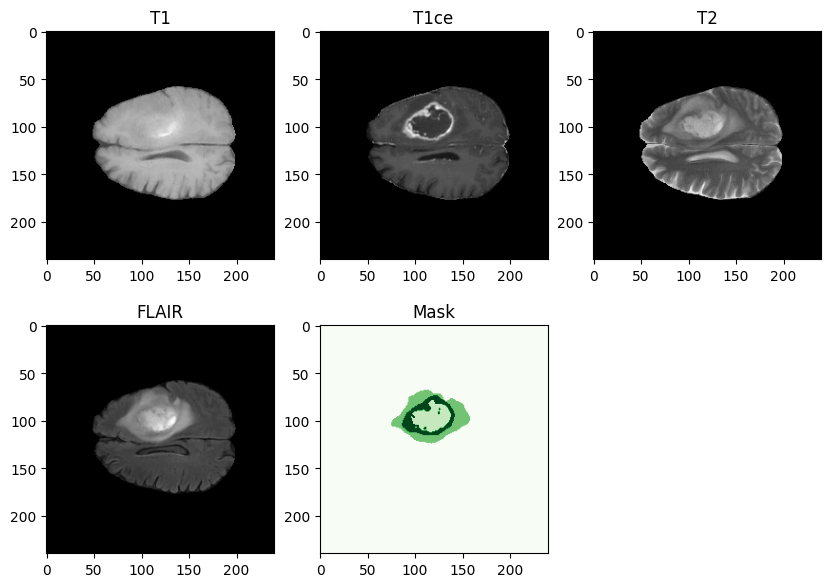

In [8]:
slice = 95

print("Slice Number: " + str(slice))

plt.figure(figsize=(10, 7))

# T1
plt.subplot(2, 3, 1)
plt.imshow(test_image_t1[:,:,slice], cmap='gray')
plt.title('T1')

# T1ce
plt.subplot(2, 3, 2)
plt.imshow(test_image_t1ce[:,:,slice], cmap='gray')
plt.title('T1ce')

# T2
plt.subplot(2, 3, 3)
plt.imshow(test_image_t2[:,:,slice], cmap='gray')
plt.title('T2')

# Flair
plt.subplot(2, 3, 4)
plt.imshow(test_image_flair[:,:,slice], cmap='gray')
plt.title('FLAIR')

# Mask
plt.subplot(2, 3, 5)
plt.imshow(test_image_seg[:,:,slice], cmap='Greens')
plt.title('Mask')
plt.show()

In [9]:
# Modality shape
print("Modality: ", test_image_t1.shape)

# Segmentation shape
print("Segmentation: ", test_image_seg.shape)

# (width, height, slice)

Modality:  (240, 240, 155)
Segmentation:  (240, 240, 155)


Slice number: 95


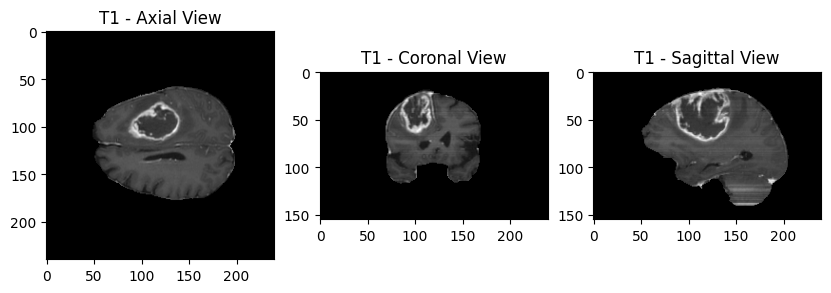

In [10]:
slice = 95

print("Slice number: " + str(slice))

plt.figure(figsize=(10, 6))

# Apply a 90° rotation with an automatic resizing, otherwise the display is less obvious to analyze
# T1 - Transverse View
plt.subplot(1, 3, 1)
plt.imshow(test_image_t1ce[:,:,slice], cmap='gray')
plt.title('T1 - Axial View')

# T1 - Frontal View
plt.subplot(1, 3, 2)
plt.imshow(rotate(test_image_t1ce[:,slice,:], 90, resize=True), cmap='gray')
plt.title('T1 - Coronal View')

# T1 - Sagittal View
plt.subplot(1, 3, 3)
plt.imshow(rotate(test_image_t1ce[slice,:,:], 90, resize=True), cmap='gray')
plt.title('T1 - Sagittal View')
plt.show()

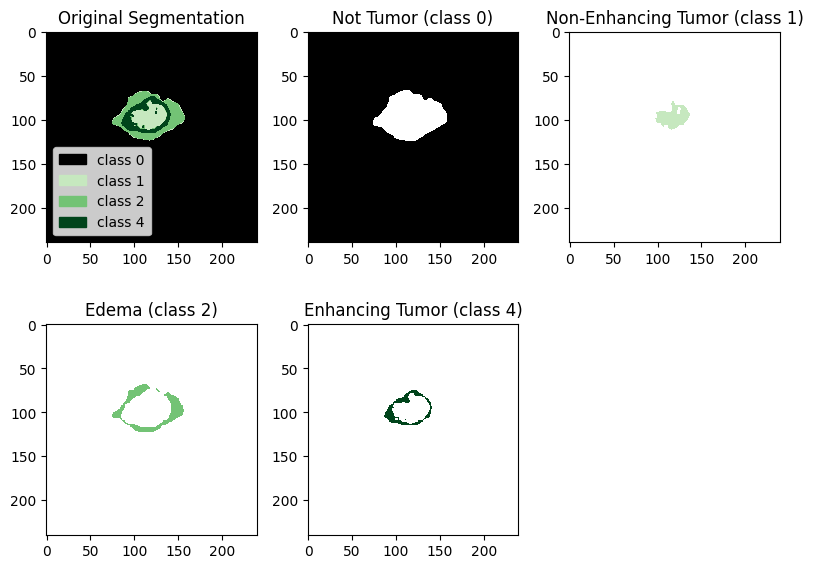

In [11]:
# Isolation of class 0
seg_0 = test_image_seg.copy()
seg_0[seg_0 != 0] = np.nan

# Isolation of class 1
seg_1 = test_image_seg.copy()
seg_1[seg_1 != 1] = np.nan

# Isolation of class 2
seg_2 = test_image_seg.copy()
seg_2[seg_2 != 2] = np.nan

# Isolation of class 4
seg_4 = test_image_seg.copy()
seg_4[seg_4 != 4] = np.nan

# Plotting the segmantation
cmap = matplotlib.colors.ListedColormap(['#000000', '#C6E8BF', '#73C375', '#00441B'])
norm = matplotlib.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

# Define legend
class_names = ['class 0', 'class 1', 'class 2', 'class 4']
legend = [plt.Rectangle((0, 0), 1, 1, color=cmap(i), label=class_names[i]) for i in range(len(class_names))]

fig, ax = plt.subplots(2, 3, figsize=(8, 6))

ax[0, 0].imshow(test_image_seg[:,:, slice], cmap=cmap, norm=norm)
ax[0, 0].set_title('Original Segmentation')
ax[0, 0].legend(handles=legend, loc='lower left')

ax[0, 1].imshow(seg_0[:,:, slice], cmap=cmap, norm=norm)
ax[0, 1].set_title('Not Tumor (class 0)')

ax[0, 2].imshow(seg_1[:,:, slice], cmap=cmap, norm=norm)
ax[0, 2].set_title('Non-Enhancing Tumor (class 1)')

ax[1, 0].imshow(seg_2[:,:, slice], cmap=cmap, norm=norm)
ax[1, 0].set_title('Edema (class 2)')

ax[1, 1].imshow(seg_4[:,:, slice], cmap=cmap, norm=norm)
ax[1, 1].set_title('Enhancing Tumor (class 4)')

ax[1, 2].axis('off')

plt.tight_layout()
plt.show()

In [12]:
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories);

train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.1, random_state=123)
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.07, random_state=123)



In [13]:
print(f"Train length: {len(train_ids)}")
print(f"Validation length: {len(val_ids)}")
print(f"Test length: {len(test_ids)}")

Train length: 308
Validation length: 37
Test length: 24


In [14]:
# Define seg-areas
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3
}

# Select Slices and Image Size
VOLUME_SLICES = 96
VOLUME_START_AT = 25 # first slice of volume that we will include
IMG_SIZE=128

In [15]:
# yolov4 처럼 batch_size는 없애야 할듯
# __data_generation 함수 없이 그냥 __getitem__에 바로 코딩

class UnetrDataset(keras.utils.Sequence):
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), n_channels = 2, shuffle=True):
        self.dim = dim
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return len(self.list_IDs)

    def __getitem__(self, index):
        id = self.list_IDs[index]

        X = np.zeros((VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((VOLUME_SLICES, 240, 240))
        Y = np.zeros((VOLUME_SLICES, *self.dim, 4))

        case_path = os.path.join(TRAIN_DATASET_PATH, id)

        data_path = os.path.join(case_path, f'{id}_flair.nii');
        flair = nib.load(data_path).get_fdata()

        data_path = os.path.join(case_path, f'{id}_t1ce.nii');
        t1ce = nib.load(data_path).get_fdata()

        data_path = os.path.join(case_path, f'{id}_seg.nii');
        seg = nib.load(data_path).get_fdata()

        for j in range(VOLUME_SLICES):
          X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
          X[j,:,:,1] = cv2.resize(t1ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

          y[j] = seg[:,:,j+VOLUME_START_AT];

        # Generate masks
        y[y==4] = 3;
        # mask: (VOLUME_SLICES, 240, 240, 4)
        mask = tf.one_hot(y, 4);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));


        # X: (VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2)
        # Y: (VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 4)
        return X/np.max(X), Y.numpy()


training_generator = UnetrDataset(train_ids)
valid_generator = UnetrDataset(val_ids)
test_generator = UnetrDataset(test_ids)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(96, 128, 128, 2)
(96, 128, 128, 4)
(96, 128, 128)
(96, 128, 128)
(96, 128, 128)
torch.Size([2, 128, 128, 96])


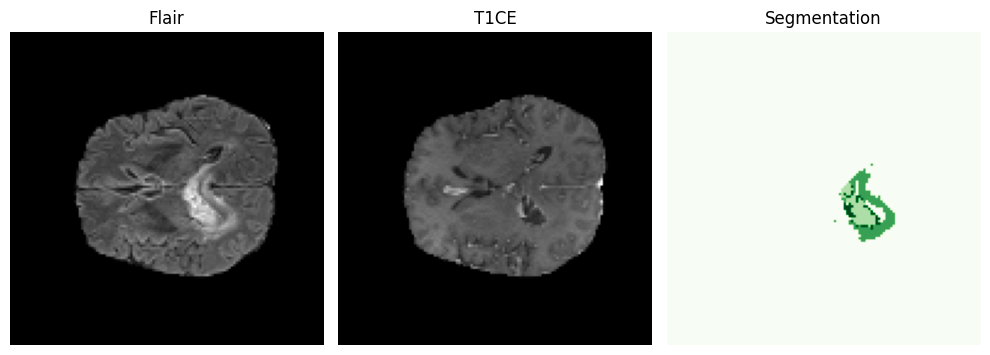

In [16]:
import torch
from torch import nn
from torch.utils.data import DataLoader

# Define a function to display one slice and its segmentation
def display_slice_and_segmentation(flair, t1ce, segmentation):
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))

    axes[0].imshow(flair, cmap='gray')
    axes[0].set_title('Flair')
    axes[0].axis('off')

    axes[1].imshow(t1ce, cmap='gray')
    axes[1].set_title('T1CE')
    axes[1].axis('off')

    axes[2].imshow(segmentation, cmap='Greens') # Displaying segmentation
    axes[2].set_title('Segmentation')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()


# Retrieve the batch from the training generator
X_batch, Y_batch = training_generator[10]

print(type(X_batch))
print(type(Y_batch))

# Extract Flair, T1CE, and segmentation from the batch
flair_batch = X_batch[:, :, :, 0]
t1ce_batch = X_batch[:, :, :, 1]

print(X_batch.shape) # (100, 128, 128, 2)
print(Y_batch.shape) # (100, 128, 128, 4)

segmentation_batch = np.argmax(Y_batch, axis=-1)  # Convert one-hot encoded to categorical

print(flair_batch.shape) # (100, 128, 128)
print(t1ce_batch.shape) # (100, 128, 128)
print(segmentation_batch.shape) # (100, 128, 128)

print(torch.from_numpy(X_batch).permute(3, 1, 2, 0).shape)

# Extract the 50th slice from Flair, T1CE, and segmentation
slice_index = 50  # Indexing starts from 0
slice_flair = flair_batch[slice_index]
slice_t1ce = t1ce_batch[slice_index]
slice_segmentation = segmentation_batch[slice_index]

# Display the 50th slice and its segmentation
display_slice_and_segmentation(slice_flair, slice_t1ce, slice_segmentation)

In [17]:
"""
from torch.utils.data import DataLoader
from tqdm import tqdm


train_loader = DataLoader(
    dataset=training_generator,
    batch_size=1,
    pin_memory=False,
    shuffle=False,
    drop_last=False,
)

cnt = 0
loop = tqdm(train_loader, leave=True)

for batch_idx, (x, y) in enumerate(loop):

  print(x.shape)
  print(y.shape)
  cnt+=1
  if cnt == 1:
    break

# Y.numpy() 하니까 드디어 해결"""

'\nfrom torch.utils.data import DataLoader\nfrom tqdm import tqdm\n\n\ntrain_loader = DataLoader(\n    dataset=training_generator,\n    batch_size=1,\n    pin_memory=False,\n    shuffle=False,\n    drop_last=False,\n)\n\ncnt = 0\nloop = tqdm(train_loader, leave=True)\n\nfor batch_idx, (x, y) in enumerate(loop):\n\n  print(x.shape)\n  print(y.shape)\n  cnt+=1\n  if cnt == 1:\n    break\n\n# Y.numpy() 하니까 드디어 해결'

In [18]:
"""
train_loader = DataLoader(
    dataset=training_generator,
    batch_size=1,
    shuffle=False,
    drop_last=False,
)
x, y = next(iter(train_loader))

print(x.shape)
print(y.shape)"""

'\ntrain_loader = DataLoader(\n    dataset=training_generator,\n    batch_size=1,\n    shuffle=False,\n    drop_last=False,\n)\nx, y = next(iter(train_loader))\n\nprint(x.shape)\nprint(y.shape)'

In [19]:
"""
x = x.permute(0, 4, 2, 3, 1).float()
print(x.shape)"""

'\nx = x.permute(0, 4, 2, 3, 1).float()\nprint(x.shape)'

In [20]:
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary
from torch import Tensor

class Embeddings(nn.Module):
    def __init__(self, input_shape, patch_size=16, embed_dim=768, dropout=0.):
        super().__init__()
        self.patch_size = patch_size
        self.in_channels = input_shape[-4]
        self.n_patches = int((input_shape[-1] * input_shape[-2] * input_shape[-3]) / (patch_size * patch_size * patch_size))
        self.embed_dim = embed_dim
        self.patch_embeddings = nn.Conv3d(in_channels=self.in_channels, out_channels=self.embed_dim,
                                          kernel_size=self.patch_size, stride=self.patch_size)
        self.position_embeddings = nn.Parameter(torch.zeros(1, self.n_patches, self.embed_dim))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.patch_embeddings(x)
        x = rearrange(x, "b n h w d -> b (h w d) n")
        # batch, embed_dim, height/patch, width/patch, depth/patch
        embeddings = x + self.position_embeddings
        embeddings = self.dropout(embeddings)
        return embeddings


In [21]:
"""
E = Embeddings(x.shape[1:]) # -> torch.Size([2, 1176, 768])
summary(E, x.shape[1:], device='cpu')

embedding_x = E(x)
print(embedding_x.shape)"""

"\nE = Embeddings(x.shape[1:]) # -> torch.Size([2, 1176, 768])\nsummary(E, x.shape[1:], device='cpu')\n\nembedding_x = E(x)\nprint(embedding_x.shape)"

In [22]:
class MultiHeadAttentionBlock(nn.Module):
  def __init__(self, d_model: int = 768, n_head: int = 8, dropout: float = 0.1):
    super().__init__()
    self.d_model = d_model
    self.n_head = n_head
    assert d_model % n_head == 0, "d_model is not divisible by n_head"
    self.d_k = d_model // n_head

    self.query = nn.Linear(d_model, d_model, bias=False)
    self.key = nn.Linear(d_model, d_model, bias=False)
    self.value = nn.Linear(d_model, d_model, bias=False)

    self.scale = math.sqrt(self.d_k)

    self.dense = nn.Linear(d_model, d_model, bias=False)
    self.dropout = nn.Dropout(dropout)

  def scaled_dot_product_attention(self, query, key, value, mask):
    # (Seq_len, d_k) -> (Seq_len, Seq_len)

    matmul_qk = query @ key.transpose(-2, -1)

    scaled_attention_logits = matmul_qk / self.scale

    if mask is not None:
      scaled_attention_logits.masked_fill_(mask == 0, -1e9) # if mask == 0 fill it as -1e9 (sim -inf)

    attention_score = scaled_attention_logits.softmax(dim=-1)
    attention_weights = self.dropout(attention_score)
    x = attention_weights @ value

    return x, attention_score

  def split_heads(self, x, n_head, d_k):
    # (Batch, Seq_len, d_model) -> (Batch, Seq_len, n_head, d_k) -> (Batch, n_head, Seq_len, d_k)
    x = x.view(x.shape[0], x.shape[1], n_head, d_k).transpose(1, 2)
    return x

  def forward(self, query, key, value, mask):
    Q = self.query(query) # (Seq_len, d_model) -> (Seq_len, d_model)
    K = self.key(key) # (Seq_len, d_model) -> (Seq_len, d_model)
    V = self.value(value) # (Seq_len, d_model) -> (Seq_len, d_model)

    Q = self.split_heads(Q, self.n_head, self.d_k)
    K = self.split_heads(K, self.n_head, self.d_k)
    V = self.split_heads(V, self.n_head, self.d_k)

    x, attention_score = self.scaled_dot_product_attention(Q, K, V, mask)

    # (Batch, n_head, Seq_len, d_k) -> (Batch, Seq_len, n_head, d_k) -> (Batch, Seq_len, d_model)
    concat_attention  = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.n_head * self.d_k)

    # (Batch, Seq_len, d_model) -> (Batch, Seq_len, d_model)
    return self.dense(concat_attention), attention_score

In [23]:
"""
mha = MultiHeadAttentionBlock()

mha_x = mha(embedding_x, embedding_x, embedding_x, None)

mha_x[0].shape"""

'\nmha = MultiHeadAttentionBlock()\n\nmha_x = mha(embedding_x, embedding_x, embedding_x, None)\n\nmha_x[0].shape'

In [24]:
class FeedForwardBlock(nn.Module):
  def __init__(self, d_model: int = 768, dropout: float = 0.1):
    super().__init__()
    self.ff_1 = nn.Linear(d_model, d_model * 4) # w1 and b1
    self.relu = nn.GELU()
    self.dropout = nn.Dropout(dropout)
    self.ff_2 = nn.Linear(d_model * 4, d_model) # w2 and b2

  def forward(self, x):
    x = self.ff_2(self.dropout(self.relu(self.ff_1(x))))
    return x


In [25]:
"""
FF = FeedForwardBlock()
summary(FF, mha_x[0].shape[1:], device='cpu')

ff_x = FF(mha_x[0])
print(ff_x.shape)"""

"\nFF = FeedForwardBlock()\nsummary(FF, mha_x[0].shape[1:], device='cpu')\n\nff_x = FF(mha_x[0])\nprint(ff_x.shape)"

In [26]:
class EncoderBlock(nn.Module):
  def __init__(self, d_model: int = 768, n_head: int = 8, dropout: float = 0.1):
    super().__init__()

    self.layer_norm = nn.LayerNorm(d_model)
    self.self_attention = MultiHeadAttentionBlock(d_model, n_head, dropout)
    self.feed_forward = FeedForwardBlock(d_model, dropout)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    res = x
    x = self.layer_norm(x)
    x, attention_score = self.self_attention(x, x, x, None)
    x = res + self.dropout(x)

    res = x
    x = self.layer_norm(x)
    x = self.feed_forward(x)
    x = res + self.dropout(x)

    return x


class VisionTransformer(nn.Module):
  def __init__(self, d_model: int = 768, n_head: int = 8, depth: int = 12, dropout: float = 0.1, extract: list = [3,6,9,12]):
    super().__init__()

    self.ViT = nn.ModuleList([EncoderBlock(d_model, n_head, dropout) for _ in range(depth)])
    self.extract = extract

  def forward(self, x):
    Z_layer = []

    for i, layer in enumerate(self.ViT):
      x = layer(x)
      if i+1 in self.extract:
        Z_layer.append(x)

    return Z_layer





In [27]:
"""
ViT = VisionTransformer()
#summary(ViT, embedding_x.shape[1:], device='cpu')

#for i in ViT(embedding_x):
#  print(i.shape)

z3, z6, z9, z12 = ViT(embedding_x)

print(z3.shape)
print(z6.shape)
print(z9.shape)
print(z12.shape)
"""

"\nViT = VisionTransformer()\n#summary(ViT, embedding_x.shape[1:], device='cpu')\n\n#for i in ViT(embedding_x):\n#  print(i.shape)\n\nz3, z6, z9, z12 = ViT(embedding_x)\n\nprint(z3.shape)\nprint(z6.shape)\nprint(z9.shape)\nprint(z12.shape)\n"

In [28]:
class Upsample3DBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.upsample = nn.ConvTranspose3d(in_channels, out_channels, kernel_size=2, stride=2)

  def forward(self, x):
    return self.upsample(x)

class Conv3dBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, act=True):
    super().__init__()
    self.conv3d = nn.Conv3d(in_channels, out_channels, kernel_size, stride=1, padding=((kernel_size - 1) // 2))
    self.act = act
    self.batch_norm = nn.BatchNorm3d(out_channels)
    self.relu = nn.ReLU(True)

  def forward(self, x):
    if self.act:
      return self.relu(self.batch_norm(self.conv3d(x)))
    else:
      return self.conv3d(x)

class Deconv3dBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size):
    super().__init__()
    self.deconv3d = nn.ConvTranspose3d(in_channels, out_channels, kernel_size=2, stride=2)
    self.conv3d = nn.Conv3d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=((kernel_size - 1) // 2))
    self.batch_norm = nn.BatchNorm3d(out_channels)
    self.relu = nn.ReLU(True)

  def forward(self, x):
    return self.relu(self.batch_norm(self.conv3d(self.deconv3d(x))))



In [29]:
# reference: https://www.kaggle.com/code/usharengaraju/tensorflow-unetr-w-b
# reference: https://kimbg.tistory.com/33

class UNETR(nn.Module):
  def __init__(self, img_shape=(128, 128, 96), patch_size=16, in_channels=2,
               out_channels=4, d_model=768, n_head=8, dropout=0.1, light_r=4):
    super().__init__()

    self.img_shape = img_shape
    self.patch_size = patch_size
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.d_model = d_model
    self.n_head = n_head
    self.dropout = dropout
    self.patch_dim = [int(x / patch_size) for x in img_shape]
    self.conv_channels = [int(i/light_r) for i in [32, 64, 128, 256, 512, 1024]]

    self.embedding = Embeddings((in_channels, *img_shape))

    # U-net encoder
    self.encoder = VisionTransformer()

    # U-net decoder
    self.decoder0 = nn.Sequential(
        Conv3dBlock(in_channels, self.conv_channels[0], 3),
        Conv3dBlock(self.conv_channels[0], self.conv_channels[1], 3)
    )

    self.decoder3 = nn.Sequential(
        Deconv3dBlock(d_model, self.conv_channels[2], 3),
        Deconv3dBlock(self.conv_channels[2], self.conv_channels[2], 3),
        Deconv3dBlock(self.conv_channels[2], self.conv_channels[2], 3)
    )

    self.decoder6 = nn.Sequential(
        Deconv3dBlock(d_model, self.conv_channels[3], 3),
        Deconv3dBlock(self.conv_channels[3], self.conv_channels[3], 3)
    )

    self.decoder9 = nn.Sequential(
        Deconv3dBlock(d_model, self.conv_channels[4], 3)
    )

    self.decoder12_upsampler = Upsample3DBlock(d_model, self.conv_channels[4])

    self.decoder9_upsampler = nn.Sequential(
        Conv3dBlock(self.conv_channels[5], self.conv_channels[3], 3),
        Conv3dBlock(self.conv_channels[3], self.conv_channels[3], 3),
        Conv3dBlock(self.conv_channels[3], self.conv_channels[3], 3),
        Upsample3DBlock(self.conv_channels[3], self.conv_channels[3])
    )

    self.decoder6_upsampler = nn.Sequential(
        Conv3dBlock(self.conv_channels[4], self.conv_channels[2], 3),
        Conv3dBlock(self.conv_channels[2], self.conv_channels[2], 3),
        Upsample3DBlock(self.conv_channels[2], self.conv_channels[2])
    )

    self.decoder3_upsampler = nn.Sequential(
        Conv3dBlock(self.conv_channels[3], self.conv_channels[1], 3),
        Conv3dBlock(self.conv_channels[1], self.conv_channels[1], 3),
        Upsample3DBlock(self.conv_channels[1], self.conv_channels[1])
    )

    self.decoder0_header = nn.Sequential(
        Conv3dBlock(self.conv_channels[2], self.conv_channels[1], 3),
        Conv3dBlock(self.conv_channels[1], self.conv_channels[1], 3),
        Conv3dBlock(self.conv_channels[1], out_channels, 1, act=False)
    )

  def forward(self, x):
    z0 = x

    # x = (1, 1176, 768)
    x = self.embedding(x)

    # z = (1, 1176, 768)
    z3, z6, z9, z12 = self.encoder(x)

    # z = (1, 768, 14, 14, 6)
    z3 = z3.transpose(-1, -2).view(-1, self.d_model, *self.patch_dim)
    z6 = z6.transpose(-1, -2).view(-1, self.d_model, *self.patch_dim)
    z9 = z9.transpose(-1, -2).view(-1, self.d_model, *self.patch_dim)
    z12 = z12.transpose(-1, -2).view(-1, self.d_model, *self.patch_dim)

    z12 = self.decoder12_upsampler(z12)
    z9 = self.decoder9(z9)
    z9 = self.decoder9_upsampler(torch.cat([z9, z12], dim=1))
    z6 = self.decoder6(z6)
    z6 = self.decoder6_upsampler(torch.cat([z6, z9], dim=1))
    z3 = self.decoder3(z3)
    z3 = self.decoder3_upsampler(torch.cat([z3, z6], dim=1))
    z0 = self.decoder0(z0)
    output = self.decoder0_header(torch.cat([z0, z3], dim=1))

    return output


In [30]:
"""
unetr = UNETR()
pred = unetr(x)
print(pred.shape)"""

'\nunetr = UNETR()\npred = unetr(x)\nprint(pred.shape)'

In [31]:
"""

import torch.nn as nn

def DiceLoss(pred, target):
  # bce = nn.BCEWithLogitsLoss(reduction='mean')
  # bce_loss = bce(pred, target)

  smooth = 1e-5
  pred = torch.sigmoid(pred)
  target = target.float()

  intersection = (pred * target).sum(dim=(2, 3, 4)) # H W D
  union = pred.sum(dim=(2, 3, 4)) + target.sum(dim=(2, 3, 4))

  dice = (2. * intersection + smooth) / (union + smooth)
  dice_loss = 1 - dice

  return dice_loss.mean()

def DiceScore(pred, target):
  smooth = 1e-5
  pred = torch.sigmoid(pred)
  pred = (pred > 0.5).float()
  target = target.float()

  intersection = (pred * target).sum(dim=(2, 3, 4)) # H W D
  union = pred.sum(dim=(2, 3, 4)) + target.sum(dim=(2, 3, 4))

  dice = (2. * intersection + smooth) / (union + smooth)

  return dice.mean()

"""


"\n\nimport torch.nn as nn\n\ndef DiceLoss(pred, target):\n  # bce = nn.BCEWithLogitsLoss(reduction='mean')\n  # bce_loss = bce(pred, target)\n\n  smooth = 1e-5\n  pred = torch.sigmoid(pred)\n  target = target.float()\n\n  intersection = (pred * target).sum(dim=(2, 3, 4)) # H W D\n  union = pred.sum(dim=(2, 3, 4)) + target.sum(dim=(2, 3, 4))\n\n  dice = (2. * intersection + smooth) / (union + smooth)\n  dice_loss = 1 - dice\n\n  return dice_loss.mean()\n\ndef DiceScore(pred, target):\n  smooth = 1e-5\n  pred = torch.sigmoid(pred)\n  pred = (pred > 0.5).float()\n  target = target.float()\n\n  intersection = (pred * target).sum(dim=(2, 3, 4)) # H W D\n  union = pred.sum(dim=(2, 3, 4)) + target.sum(dim=(2, 3, 4))\n\n  dice = (2. * intersection + smooth) / (union + smooth)\n\n  return dice.mean()\n\n"

In [32]:
# dice_loss = DiceLoss(pred, y)
# dice_score = DiceScore(pred, y)

# print(dice_loss)
# print(dice_score)

In [33]:
!pip install monai

In [34]:
import monai
from monai.losses import DiceCELoss, DiceLoss

torch.backends.cudnn.benchmark = True

LossFuncion = monai.losses.DiceLoss(include_background=False, to_onehot_y=False, softmax=True)
MetricDice = monai.metrics.DiceMetric(include_background=False, reduction="mean")


def BinaryOutput(output, keepdim=True):
    shape = output.shape
    argmax_idx = torch.argmax(output, axis=1, keepdim=True)
    argmax_oh = F.one_hot(argmax_idx, num_classes=4)
    if keepdim:
        argmax_oh = torch.squeeze(argmax_oh, dim=1)
    if len(shape) == 5:
        argmax_oh = argmax_oh.permute(0,4,1,2,3)
    elif len(shape) == 4:
        argmax_oh = argmax_oh.permute(0,3,1,2)

    return argmax_oh

In [35]:
from torch.utils.data import DataLoader

training_generator = UnetrDataset(train_ids)
valid_generator = UnetrDataset(val_ids)
test_generator = UnetrDataset(test_ids)

train_loader = DataLoader(
    dataset=training_generator,
    batch_size=4,
    num_workers=0,
    pin_memory=True,
    shuffle=True,
    drop_last=False,
)

valid_loader = DataLoader(
    dataset=valid_generator,
    batch_size=1,
    num_workers=0,
    pin_memory=True,
    shuffle=False,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_generator,
    batch_size=1,
    num_workers=0,
    pin_memory=True,
    shuffle=False,
    drop_last=False,
)

In [36]:
"""
x, y = next(iter(train_loader))
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model = UNETR().to(DEVICE)

x = x.permute(0, 4, 2, 3, 1).float()
y = y.permute(0, 4, 2, 3, 1).float()
x = x.to(DEVICE)
y = y.to(DEVICE)
pred = model(x)
loss = LossFuncion(pred, y)

print(loss)"""



'\nx, y = next(iter(train_loader))\nDEVICE = "cuda" if torch.cuda.is_available() else "cpu"\n\nmodel = UNETR().to(DEVICE)\n\nx = x.permute(0, 4, 2, 3, 1).float()\ny = y.permute(0, 4, 2, 3, 1).float()\nx = x.to(DEVICE)\ny = y.to(DEVICE)\npred = model(x)\nloss = LossFuncion(pred, y)\n\nprint(loss)'

In [37]:
from tqdm import tqdm
from monai.losses.dice import DiceLoss, one_hot
# batch size, img size, light_r 적정값 찾아야 함

def train(model, optimizer, train_loader, DEVICE):
  model.train()
  batch_loss = []
  epoch_loss = 0
  epoch_dice_scores = 0

  loop = tqdm(train_loader, leave=True)

  for batch_idx, (x, y) in enumerate(loop):

    x = x.permute(0, 4, 2, 3, 1).float()
    y = y.permute(0, 4, 2, 3, 1).float()
    y = np.argmax(y, axis=1)
    y = one_hot(y[:, None, ...], num_classes=4)
    x = x.to(DEVICE)
    y = y.to(DEVICE)

    pred = model(x)

    loss = LossFuncion(pred, y)
    loss.backward()
    optimizer.zero_grad()
    epoch_loss += loss.item()

    bi_output = BinaryOutput(pred)
    MetricDice(bi_output, y)
    dice_score = MetricDice.aggregate().item()
    epoch_dice_scores += dice_score


    batch_loss.append(loss.item())
    mean_loss = sum(batch_loss) / len(batch_loss)
    loop.set_postfix(loss=mean_loss)

  avg_loss = epoch_loss / len(train_loader)
  avg_dice_score = epoch_dice_scores / len(train_loader)

  return avg_loss, avg_dice_score


def eval(model, optimizer, valid_loader, DEVICE):
  model.eval()
  epoch_loss = 0
  epoch_dice_scores = 0

  loop = tqdm(valid_loader, leave=True)

  with torch.no_grad():
    for batch_idx, (x, y) in enumerate(loop):

      x = x.permute(0, 4, 2, 3, 1).float()
      y = y.permute(0, 4, 2, 3, 1).float()
      x = x.to(DEVICE)
      y = y.to(DEVICE)

      pred = model(x)

      loss = LossFuncion(pred, y)
      epoch_loss += loss.item()

      bi_output = BinaryOutput(pred)
      MetricDice(bi_output, y)
      dice_score = MetricDice.aggregate().item()
      epoch_dice_scores += dice_score

  avg_loss = epoch_loss / len(train_loader)
  avg_dice_score = epoch_dice_scores / len(train_loader)

  MetricDice.reset()

  return avg_loss, avg_dice_score


EPOCHS = 5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_SAVE = True
model = UNETR().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
best_loss = 999
best_epoch = -1

def save_checkpoint(model, optimizer, filename):
  checkpoint = {
      "state_dict": model.state_dict(),
      "optimizer": optimizer.state_dict(),
  }
  torch.save(checkpoint, filename)

for epoch in range(1, EPOCHS+1):

  avg_loss, avg_dice_score = train(model, optimizer, train_loader, DEVICE)

  if avg_loss < best_loss or epoch == 1:
    best_loss = avg_loss
    best_epoch = epoch
    print(f"Epoch: {epoch}/{EPOCHS}, Loss: {avg_loss:.4f}, Dice Score: {avg_dice_score:.4f}")

    if MODEL_SAVE and epoch != 1:
      filename = './unter_weights.pth'
      save_checkpoint(model, optimizer, filename)

  if epoch % 2 == 0:
    avg_loss, avg_dice_score = eval(model, optimizer, valid_loader, DEVICE)
    print(f"Validation in Epoch: {epoch}/{EPOCHS}, Loss: {avg_loss:.4f}, Dice Score: {avg_dice_score:.4f}")



100%|██████████| 77/77 [04:31<00:00,  3.53s/it, loss=0.987]


Epoch: 1/5, Loss: 0.9871, Dice Score: 0.0128


100%|██████████| 77/77 [03:25<00:00,  2.67s/it, loss=0.987]


Epoch: 2/5, Loss: 0.9870, Dice Score: 0.0134


  3%|▎         | 1/37 [00:04<02:53,  4.83s/it]

tensor([[[[[ 1.9805e-01,  1.2805e-01,  2.2867e-01,  ...,  9.6238e-02,
             2.2832e-01,  2.9576e-01],
           [ 2.9132e-01,  1.6179e-01,  2.3917e-02,  ...,  1.1959e-01,
             1.4211e-01,  1.9428e-01],
           [ 2.2388e-01,  9.0456e-02,  1.1175e-01,  ..., -1.3341e-01,
             1.5972e-01,  3.1687e-01],
           ...,
           [ 1.2410e-01,  6.1759e-02,  4.4358e-02,  ...,  1.3780e-02,
             4.4281e-02,  2.9074e-01],
           [ 2.7854e-01,  1.6874e-01,  1.5092e-01,  ...,  8.8297e-03,
             2.0448e-01,  2.8203e-01],
           [-1.6455e-02, -4.9235e-02, -8.9051e-03,  ..., -1.8461e-01,
            -3.6276e-02,  1.3605e-01]],

          [[-2.7072e-02,  1.9669e-02, -1.2807e-02,  ...,  1.3416e-01,
             1.7587e-01,  1.8095e-01],
           [ 2.8019e-01,  8.6321e-02,  1.1059e-01,  ...,  5.4238e-02,
             1.2036e-01,  1.0470e-01],
           [ 1.9615e-01,  1.2119e-01, -1.3380e-01,  ..., -2.5869e-01,
            -2.6671e-01,  2.0389e-01],
 

  5%|▌         | 2/37 [00:05<01:18,  2.24s/it]

tensor([[[[[ 1.9744e-01,  1.2758e-01,  2.3401e-01,  ...,  9.8099e-02,
             2.2923e-01,  2.9623e-01],
           [ 2.9030e-01,  1.6586e-01,  2.6931e-02,  ...,  1.1823e-01,
             1.4488e-01,  1.9337e-01],
           [ 2.2331e-01,  8.7853e-02,  1.0409e-01,  ..., -1.3096e-01,
             1.5803e-01,  3.1910e-01],
           ...,
           [ 1.2065e-01,  6.1208e-02,  4.5983e-02,  ...,  1.2147e-02,
             4.4167e-02,  2.8914e-01],
           [ 2.8006e-01,  1.6907e-01,  1.5017e-01,  ...,  7.3919e-03,
             2.0320e-01,  2.8235e-01],
           [-1.7034e-02, -4.9042e-02, -5.4047e-03,  ..., -1.8111e-01,
            -3.9437e-02,  1.3638e-01]],

          [[-2.7270e-02,  1.9472e-02, -1.2520e-02,  ...,  1.3417e-01,
             1.7388e-01,  1.8221e-01],
           [ 2.7972e-01,  8.5655e-02,  1.0883e-01,  ...,  5.4568e-02,
             1.1968e-01,  1.0684e-01],
           [ 1.9464e-01,  1.1953e-01, -1.3155e-01,  ..., -2.5664e-01,
            -2.6847e-01,  2.0419e-01],
 

  8%|▊         | 3/37 [00:05<00:47,  1.39s/it]

tensor([[[[[ 2.0291e-01,  1.2998e-01,  2.2749e-01,  ...,  9.7304e-02,
             2.2646e-01,  2.9585e-01],
           [ 2.9253e-01,  1.6625e-01,  1.8463e-02,  ...,  1.0822e-01,
             1.5034e-01,  1.9567e-01],
           [ 2.2329e-01,  9.5718e-02,  1.0787e-01,  ..., -1.3501e-01,
             1.5569e-01,  3.1354e-01],
           ...,
           [ 1.2798e-01,  5.6632e-02,  4.3557e-02,  ...,  3.0837e-02,
             5.3179e-02,  2.9069e-01],
           [ 2.8115e-01,  1.7309e-01,  1.5510e-01,  ...,  1.7557e-02,
             2.0996e-01,  2.8657e-01],
           [-1.7421e-02, -5.0146e-02, -4.6590e-03,  ..., -1.9393e-01,
            -3.6864e-02,  1.3781e-01]],

          [[-2.3163e-02,  2.4023e-02, -1.4584e-02,  ...,  1.4110e-01,
             1.8444e-01,  1.8885e-01],
           [ 2.8548e-01,  8.3451e-02,  1.2307e-01,  ...,  4.2767e-02,
             1.2555e-01,  9.9986e-02],
           [ 1.9372e-01,  1.3431e-01, -1.3726e-01,  ..., -2.6334e-01,
            -2.8014e-01,  2.2069e-01],
 

 11%|█         | 4/37 [00:06<00:32,  1.01it/s]

tensor([[[[[ 1.9717e-01,  1.2616e-01,  2.2899e-01,  ...,  9.5809e-02,
             2.2800e-01,  2.9457e-01],
           [ 2.9154e-01,  1.6170e-01,  2.6962e-02,  ...,  1.1691e-01,
             1.4484e-01,  1.9432e-01],
           [ 2.2495e-01,  9.2329e-02,  1.1018e-01,  ..., -1.3415e-01,
             1.6167e-01,  3.1614e-01],
           ...,
           [ 1.2615e-01,  6.2793e-02,  4.5695e-02,  ...,  1.2703e-02,
             4.5539e-02,  2.8954e-01],
           [ 2.7827e-01,  1.6697e-01,  1.5049e-01,  ...,  9.7788e-03,
             2.0372e-01,  2.8241e-01],
           [-1.6225e-02, -4.6634e-02, -9.9801e-03,  ..., -1.8271e-01,
            -3.6135e-02,  1.3656e-01]],

          [[-2.8188e-02,  2.1557e-02, -9.8277e-03,  ...,  1.3581e-01,
             1.7653e-01,  1.8004e-01],
           [ 2.7923e-01,  9.0292e-02,  1.1119e-01,  ...,  6.1986e-02,
             1.1830e-01,  1.0271e-01],
           [ 1.9413e-01,  1.2158e-01, -1.3022e-01,  ..., -2.5952e-01,
            -2.6607e-01,  2.0427e-01],
 

 14%|█▎        | 5/37 [00:06<00:24,  1.30it/s]

tensor([[[[[ 1.9981e-01,  1.3010e-01,  2.3436e-01,  ...,  9.8198e-02,
             2.3007e-01,  2.9525e-01],
           [ 2.8880e-01,  1.6861e-01,  2.3855e-02,  ...,  1.1588e-01,
             1.4408e-01,  1.9498e-01],
           [ 2.2365e-01,  9.1815e-02,  1.0748e-01,  ..., -1.3834e-01,
             1.5377e-01,  3.1776e-01],
           ...,
           [ 1.2642e-01,  5.7133e-02,  4.4222e-02,  ...,  2.2542e-02,
             4.5494e-02,  2.8854e-01],
           [ 2.8151e-01,  1.7073e-01,  1.5347e-01,  ...,  1.2448e-02,
             2.0713e-01,  2.8492e-01],
           [-1.9811e-02, -5.3137e-02, -1.7619e-03,  ..., -1.9164e-01,
            -3.8979e-02,  1.3635e-01]],

          [[-2.5916e-02,  1.5688e-02, -1.6435e-02,  ...,  1.3370e-01,
             1.7898e-01,  1.8485e-01],
           [ 2.8352e-01,  8.1800e-02,  1.1205e-01,  ...,  4.4367e-02,
             1.2184e-01,  1.0812e-01],
           [ 2.0002e-01,  1.3011e-01, -1.3835e-01,  ..., -2.6078e-01,
            -2.7490e-01,  2.1370e-01],
 

 16%|█▌        | 6/37 [00:06<00:19,  1.58it/s]

tensor([[[[[ 1.9758e-01,  1.2992e-01,  2.3179e-01,  ...,  9.8234e-02,
             2.3004e-01,  2.9751e-01],
           [ 2.9010e-01,  1.6630e-01,  3.0027e-02,  ...,  1.1833e-01,
             1.4397e-01,  1.9320e-01],
           [ 2.2246e-01,  9.0868e-02,  1.0582e-01,  ..., -1.3453e-01,
             1.5521e-01,  3.1919e-01],
           ...,
           [ 1.1989e-01,  6.1029e-02,  4.7732e-02,  ...,  1.0765e-02,
             4.3199e-02,  2.8819e-01],
           [ 2.8100e-01,  1.6709e-01,  1.5181e-01,  ...,  7.2861e-03,
             2.0266e-01,  2.8285e-01],
           [-1.7278e-02, -5.1594e-02, -4.3767e-03,  ..., -1.8087e-01,
            -3.9442e-02,  1.3634e-01]],

          [[-2.9704e-02,  1.7905e-02, -1.2655e-02,  ...,  1.3097e-01,
             1.7312e-01,  1.8186e-01],
           [ 2.8188e-01,  8.2932e-02,  1.0887e-01,  ...,  5.5914e-02,
             1.1773e-01,  1.0621e-01],
           [ 2.0042e-01,  1.1902e-01, -1.3158e-01,  ..., -2.5754e-01,
            -2.6903e-01,  2.0041e-01],
 

 19%|█▉        | 7/37 [00:07<00:16,  1.82it/s]

tensor([[[[[ 1.9522e-01,  1.2993e-01,  2.3035e-01,  ...,  9.7569e-02,
             2.2917e-01,  2.9926e-01],
           [ 2.8846e-01,  1.6425e-01,  2.9729e-02,  ...,  1.1357e-01,
             1.4373e-01,  1.9436e-01],
           [ 2.2342e-01,  8.7360e-02,  1.0364e-01,  ..., -1.3839e-01,
             1.5681e-01,  3.1948e-01],
           ...,
           [ 1.2084e-01,  6.2403e-02,  4.7459e-02,  ...,  1.1252e-02,
             4.2258e-02,  2.8833e-01],
           [ 2.7903e-01,  1.6656e-01,  1.4909e-01,  ...,  5.6591e-03,
             2.0082e-01,  2.8277e-01],
           [-1.6851e-02, -4.9979e-02, -5.4857e-03,  ..., -1.7947e-01,
            -3.8935e-02,  1.3645e-01]],

          [[-3.2046e-02,  1.7022e-02, -9.2257e-03,  ...,  1.2975e-01,
             1.7108e-01,  1.8073e-01],
           [ 2.8289e-01,  8.6460e-02,  1.0796e-01,  ...,  6.1608e-02,
             1.1571e-01,  1.0773e-01],
           [ 2.0363e-01,  1.1698e-01, -1.2790e-01,  ..., -2.5794e-01,
            -2.6775e-01,  1.9764e-01],
 

 22%|██▏       | 8/37 [00:07<00:14,  2.02it/s]

tensor([[[[[ 1.9814e-01,  1.2793e-01,  2.3075e-01,  ...,  9.6284e-02,
             2.2837e-01,  2.9369e-01],
           [ 2.9124e-01,  1.6412e-01,  2.3628e-02,  ...,  1.1831e-01,
             1.4572e-01,  1.9409e-01],
           [ 2.2530e-01,  8.9857e-02,  1.0954e-01,  ..., -1.3219e-01,
             1.6184e-01,  3.1773e-01],
           ...,
           [ 1.2332e-01,  6.1388e-02,  4.4798e-02,  ...,  1.5360e-02,
             4.5958e-02,  2.9153e-01],
           [ 2.7953e-01,  1.6909e-01,  1.5217e-01,  ...,  1.0039e-02,
             2.0589e-01,  2.8259e-01],
           [-1.6088e-02, -4.6163e-02, -8.6341e-03,  ..., -1.8739e-01,
            -3.8170e-02,  1.3589e-01]],

          [[-2.4407e-02,  1.8698e-02, -1.2794e-02,  ...,  1.3732e-01,
             1.7621e-01,  1.8215e-01],
           [ 2.8022e-01,  8.6231e-02,  1.1503e-01,  ...,  5.5203e-02,
             1.2112e-01,  1.0484e-01],
           [ 1.9148e-01,  1.2430e-01, -1.3301e-01,  ..., -2.5757e-01,
            -2.6898e-01,  2.0460e-01],
 

 24%|██▍       | 9/37 [00:07<00:12,  2.17it/s]

tensor([[[[[ 1.9969e-01,  1.2950e-01,  2.3376e-01,  ...,  9.6528e-02,
             2.3047e-01,  2.9445e-01],
           [ 2.9023e-01,  1.6785e-01,  2.1794e-02,  ...,  1.1373e-01,
             1.4606e-01,  1.9535e-01],
           [ 2.2541e-01,  8.9078e-02,  1.1091e-01,  ..., -1.3544e-01,
             1.5510e-01,  3.1779e-01],
           ...,
           [ 1.2555e-01,  5.7900e-02,  4.3756e-02,  ...,  2.1522e-02,
             4.6121e-02,  2.9048e-01],
           [ 2.8028e-01,  1.7136e-01,  1.5392e-01,  ...,  1.1326e-02,
             2.0824e-01,  2.8408e-01],
           [-1.7118e-02, -5.1533e-02, -4.9980e-03,  ..., -1.9240e-01,
            -3.8616e-02,  1.3675e-01]],

          [[-2.4464e-02,  1.7124e-02, -1.3992e-02,  ...,  1.3623e-01,
             1.7944e-01,  1.8347e-01],
           [ 2.8276e-01,  8.2139e-02,  1.1690e-01,  ...,  4.6005e-02,
             1.2194e-01,  1.0409e-01],
           [ 1.9735e-01,  1.2781e-01, -1.3635e-01,  ..., -2.6075e-01,
            -2.7592e-01,  2.1479e-01],
 

 27%|██▋       | 10/37 [00:08<00:11,  2.29it/s]

tensor([[[[[ 2.0425e-01,  1.3154e-01,  2.2245e-01,  ...,  9.9068e-02,
             2.2661e-01,  2.9675e-01],
           [ 2.9606e-01,  1.6607e-01,  1.8313e-02,  ...,  1.0650e-01,
             1.5850e-01,  1.9664e-01],
           [ 2.2032e-01,  1.0586e-01,  1.0395e-01,  ..., -1.2782e-01,
             1.4647e-01,  3.1604e-01],
           ...,
           [ 1.3065e-01,  5.4844e-02,  4.7619e-02,  ...,  3.5434e-02,
             5.6698e-02,  2.9295e-01],
           [ 2.8347e-01,  1.7709e-01,  1.5480e-01,  ...,  1.8375e-02,
             2.1545e-01,  2.8880e-01],
           [-1.9247e-02, -5.0059e-02,  3.9070e-03,  ..., -2.0030e-01,
            -3.5124e-02,  1.3906e-01]],

          [[-2.1590e-02,  2.3097e-02, -1.5748e-02,  ...,  1.4183e-01,
             1.8738e-01,  1.9247e-01],
           [ 2.9120e-01,  7.9386e-02,  1.2956e-01,  ...,  3.3008e-02,
             1.2133e-01,  1.0149e-01],
           [ 1.9771e-01,  1.3156e-01, -1.4078e-01,  ..., -2.5662e-01,
            -2.8467e-01,  2.3077e-01],
 

 30%|██▉       | 11/37 [00:08<00:10,  2.39it/s]

tensor([[[[[ 1.9803e-01,  1.2821e-01,  2.3368e-01,  ...,  9.6967e-02,
             2.2971e-01,  2.9541e-01],
           [ 2.8915e-01,  1.6646e-01,  2.6212e-02,  ...,  1.1763e-01,
             1.4576e-01,  1.9316e-01],
           [ 2.2350e-01,  8.7977e-02,  1.0452e-01,  ..., -1.3475e-01,
             1.5889e-01,  3.1955e-01],
           ...,
           [ 1.2091e-01,  6.1605e-02,  4.6292e-02,  ...,  1.2402e-02,
             4.4048e-02,  2.8930e-01],
           [ 2.8001e-01,  1.6707e-01,  1.5102e-01,  ...,  9.9346e-03,
             2.0312e-01,  2.8325e-01],
           [-1.6337e-02, -4.8762e-02, -6.1941e-03,  ..., -1.8351e-01,
            -3.9806e-02,  1.3648e-01]],

          [[-2.7076e-02,  1.5525e-02, -1.2008e-02,  ...,  1.3408e-01,
             1.7403e-01,  1.8101e-01],
           [ 2.8040e-01,  8.5619e-02,  1.1046e-01,  ...,  5.2981e-02,
             1.2015e-01,  1.0668e-01],
           [ 1.9549e-01,  1.2340e-01, -1.3178e-01,  ..., -2.5731e-01,
            -2.6909e-01,  2.0310e-01],
 

 32%|███▏      | 12/37 [00:09<00:10,  2.44it/s]

tensor([[[[[ 1.9741e-01,  1.2857e-01,  2.3033e-01,  ...,  9.5438e-02,
             2.2827e-01,  2.9495e-01],
           [ 2.9054e-01,  1.6344e-01,  2.6085e-02,  ...,  1.1720e-01,
             1.4089e-01,  1.9529e-01],
           [ 2.2491e-01,  9.1372e-02,  1.1164e-01,  ..., -1.3403e-01,
             1.6062e-01,  3.1639e-01],
           ...,
           [ 1.2257e-01,  6.2038e-02,  4.2694e-02,  ...,  1.6737e-02,
             4.4789e-02,  2.9103e-01],
           [ 2.7837e-01,  1.6869e-01,  1.5318e-01,  ...,  6.7295e-03,
             2.0336e-01,  2.8198e-01],
           [-1.5973e-02, -5.1051e-02, -7.3028e-03,  ..., -1.8688e-01,
            -3.9024e-02,  1.3608e-01]],

          [[-2.8388e-02,  2.1802e-02, -1.3458e-02,  ...,  1.3479e-01,
             1.7761e-01,  1.8106e-01],
           [ 2.8063e-01,  8.5928e-02,  1.0795e-01,  ...,  5.5689e-02,
             1.2030e-01,  1.0573e-01],
           [ 1.9828e-01,  1.1675e-01, -1.3346e-01,  ..., -2.6122e-01,
            -2.6741e-01,  2.0652e-01],
 

 35%|███▌      | 13/37 [00:09<00:09,  2.49it/s]

tensor([[[[[ 2.0115e-01,  1.3200e-01,  2.3369e-01,  ...,  9.8030e-02,
             2.3047e-01,  2.9646e-01],
           [ 2.8740e-01,  1.7076e-01,  2.2971e-02,  ...,  1.1373e-01,
             1.4427e-01,  1.9397e-01],
           [ 2.2297e-01,  9.3122e-02,  1.0364e-01,  ..., -1.3948e-01,
             1.4872e-01,  3.1840e-01],
           ...,
           [ 1.2632e-01,  5.4526e-02,  4.2945e-02,  ...,  1.9453e-02,
             4.5143e-02,  2.8787e-01],
           [ 2.8250e-01,  1.7112e-01,  1.5383e-01,  ...,  1.1701e-02,
             2.0727e-01,  2.8468e-01],
           [-2.1517e-02, -5.5336e-02, -4.1336e-05,  ..., -1.9184e-01,
            -3.9402e-02,  1.3671e-01]],

          [[-2.6432e-02,  1.8791e-02, -1.8218e-02,  ...,  1.3361e-01,
             1.7761e-01,  1.8300e-01],
           [ 2.8640e-01,  7.9126e-02,  1.1438e-01,  ...,  4.3484e-02,
             1.2097e-01,  1.0871e-01],
           [ 1.9925e-01,  1.3358e-01, -1.3760e-01,  ..., -2.6201e-01,
            -2.7674e-01,  2.1634e-01],
 

 38%|███▊      | 14/37 [00:09<00:09,  2.52it/s]

tensor([[[[[ 1.9977e-01,  1.3204e-01,  2.3615e-01,  ...,  9.8773e-02,
             2.3078e-01,  2.9835e-01],
           [ 2.8416e-01,  1.7122e-01,  2.7240e-02,  ...,  1.1707e-01,
             1.4433e-01,  1.9172e-01],
           [ 2.2102e-01,  8.7312e-02,  1.0039e-01,  ..., -1.3721e-01,
             1.4872e-01,  3.2007e-01],
           ...,
           [ 1.2585e-01,  5.7201e-02,  4.0909e-02,  ...,  1.3977e-02,
             4.2266e-02,  2.8798e-01],
           [ 2.8352e-01,  1.6953e-01,  1.5540e-01,  ...,  7.4316e-03,
             2.0583e-01,  2.8260e-01],
           [-2.1134e-02, -5.8946e-02,  1.1357e-03,  ..., -1.8675e-01,
            -4.1156e-02,  1.3642e-01]],

          [[-2.9317e-02,  1.7270e-02, -1.7234e-02,  ...,  1.3041e-01,
             1.7432e-01,  1.8192e-01],
           [ 2.8427e-01,  7.4641e-02,  1.0651e-01,  ...,  4.7857e-02,
             1.1962e-01,  1.1259e-01],
           [ 1.9880e-01,  1.2518e-01, -1.3515e-01,  ..., -2.5975e-01,
            -2.7261e-01,  2.1166e-01],
 

 41%|████      | 15/37 [00:10<00:08,  2.55it/s]

tensor([[[[[ 2.0052e-01,  1.3119e-01,  2.3441e-01,  ...,  9.7481e-02,
             2.2968e-01,  2.9629e-01],
           [ 2.8730e-01,  1.6918e-01,  2.6074e-02,  ...,  1.1558e-01,
             1.4481e-01,  1.9442e-01],
           [ 2.2317e-01,  9.0353e-02,  1.0502e-01,  ..., -1.3712e-01,
             1.5232e-01,  3.1855e-01],
           ...,
           [ 1.2353e-01,  5.8053e-02,  4.8322e-02,  ...,  1.5215e-02,
             4.3242e-02,  2.8935e-01],
           [ 2.8097e-01,  1.6992e-01,  1.5377e-01,  ...,  9.8120e-03,
             2.0548e-01,  2.8327e-01],
           [-1.9247e-02, -5.4077e-02, -1.5659e-03,  ..., -1.8904e-01,
            -4.1039e-02,  1.3612e-01]],

          [[-2.7043e-02,  1.8258e-02, -1.6097e-02,  ...,  1.3494e-01,
             1.7775e-01,  1.8202e-01],
           [ 2.8289e-01,  8.1703e-02,  1.1085e-01,  ...,  4.8356e-02,
             1.2154e-01,  1.0794e-01],
           [ 1.9873e-01,  1.2584e-01, -1.3718e-01,  ..., -2.6020e-01,
            -2.7339e-01,  2.0928e-01],
 

 43%|████▎     | 16/37 [00:10<00:08,  2.56it/s]

tensor([[[[[ 1.9925e-01,  1.2340e-01,  2.2775e-01,  ...,  9.3921e-02,
             2.2552e-01,  2.9127e-01],
           [ 2.9162e-01,  1.5422e-01,  1.9887e-02,  ...,  1.0909e-01,
             1.4970e-01,  1.9707e-01],
           [ 2.2458e-01,  8.6695e-02,  1.1002e-01,  ..., -1.3519e-01,
             1.6614e-01,  3.1554e-01],
           ...,
           [ 1.2808e-01,  5.9459e-02,  3.7567e-02,  ...,  2.6190e-02,
             5.2090e-02,  2.9683e-01],
           [ 2.7644e-01,  1.6685e-01,  1.5342e-01,  ...,  9.2879e-03,
             2.1248e-01,  2.8301e-01],
           [-1.4635e-02, -4.6274e-02, -9.3354e-03,  ..., -1.9343e-01,
            -3.4633e-02,  1.3605e-01]],

          [[-2.2427e-02,  2.9829e-02, -4.2876e-03,  ...,  1.4564e-01,
             1.8660e-01,  1.8276e-01],
           [ 2.8164e-01,  9.6786e-02,  1.2467e-01,  ...,  5.5114e-02,
             1.2176e-01,  9.7054e-02],
           [ 1.8173e-01,  1.2547e-01, -1.2939e-01,  ..., -2.6521e-01,
            -2.7549e-01,  2.0909e-01],
 

 46%|████▌     | 17/37 [00:10<00:07,  2.58it/s]

tensor([[[[[ 0.2000,  0.1302,  0.2342,  ...,  0.0967,  0.2294,  0.2952],
           [ 0.2897,  0.1679,  0.0258,  ...,  0.1161,  0.1444,  0.1947],
           [ 0.2229,  0.0903,  0.1077,  ..., -0.1345,  0.1556,  0.3185],
           ...,
           [ 0.1233,  0.0602,  0.0459,  ...,  0.0150,  0.0440,  0.2903],
           [ 0.2803,  0.1696,  0.1529,  ...,  0.0075,  0.2069,  0.2831],
           [-0.0183, -0.0526, -0.0053,  ..., -0.1883, -0.0392,  0.1362]],

          [[-0.0272,  0.0186, -0.0151,  ...,  0.1335,  0.1770,  0.1812],
           [ 0.2814,  0.0831,  0.1104,  ...,  0.0510,  0.1215,  0.1064],
           [ 0.1965,  0.1232, -0.1346,  ..., -0.2581, -0.2712,  0.2085],
           ...,
           [ 0.3247,  0.0377, -0.1097,  ..., -0.1062, -0.2160,  0.2449],
           [ 0.1987,  0.3753, -0.0795,  ..., -0.0311, -0.0613,  0.2779],
           [ 0.0498,  0.2022,  0.0331,  ..., -0.0737, -0.0971,  0.0796]],

          [[ 0.0292,  0.1810,  0.2816,  ...,  0.2053,  0.1934,  0.2595],
           [ 0.

 49%|████▊     | 18/37 [00:11<00:07,  2.57it/s]

tensor([[[[[ 2.0055e-01,  1.3117e-01,  2.3314e-01,  ...,  9.9568e-02,
             2.2970e-01,  2.9698e-01],
           [ 2.8749e-01,  1.7002e-01,  2.2161e-02,  ...,  1.1441e-01,
             1.4510e-01,  1.9370e-01],
           [ 2.2322e-01,  9.2686e-02,  1.0267e-01,  ..., -1.3978e-01,
             1.5100e-01,  3.1684e-01],
           ...,
           [ 1.2900e-01,  5.5803e-02,  4.4497e-02,  ...,  2.4175e-02,
             4.5892e-02,  2.8778e-01],
           [ 2.8268e-01,  1.7128e-01,  1.5671e-01,  ...,  1.1109e-02,
             2.0726e-01,  2.8565e-01],
           [-2.0603e-02, -5.5536e-02,  7.2348e-04,  ..., -1.9368e-01,
            -4.0341e-02,  1.3762e-01]],

          [[-2.6542e-02,  1.8960e-02, -1.7253e-02,  ...,  1.3382e-01,
             1.7826e-01,  1.8527e-01],
           [ 2.8510e-01,  8.0668e-02,  1.1501e-01,  ...,  3.8565e-02,
             1.2180e-01,  1.0845e-01],
           [ 2.0024e-01,  1.3448e-01, -1.3976e-01,  ..., -2.6088e-01,
            -2.8076e-01,  2.1899e-01],
 

 51%|█████▏    | 19/37 [00:11<00:06,  2.58it/s]

tensor([[[[[ 2.0126e-01,  1.2949e-01,  2.3270e-01,  ...,  9.6583e-02,
             2.3052e-01,  2.9462e-01],
           [ 2.9017e-01,  1.6768e-01,  2.1118e-02,  ...,  1.1429e-01,
             1.4733e-01,  1.9456e-01],
           [ 2.2469e-01,  9.2238e-02,  1.0899e-01,  ..., -1.3917e-01,
             1.5461e-01,  3.1629e-01],
           ...,
           [ 1.2561e-01,  5.6049e-02,  4.4503e-02,  ...,  2.0642e-02,
             4.6811e-02,  2.8955e-01],
           [ 2.8106e-01,  1.7250e-01,  1.5290e-01,  ...,  1.0997e-02,
             2.0854e-01,  2.8476e-01],
           [-1.8092e-02, -5.0866e-02, -4.1604e-03,  ..., -1.9224e-01,
            -3.8767e-02,  1.3687e-01]],

          [[-2.4541e-02,  2.0121e-02, -1.2517e-02,  ...,  1.3843e-01,
             1.8239e-01,  1.8409e-01],
           [ 2.8459e-01,  8.4532e-02,  1.2002e-01,  ...,  4.7260e-02,
             1.2127e-01,  1.0267e-01],
           [ 1.9883e-01,  1.3137e-01, -1.3683e-01,  ..., -2.6353e-01,
            -2.7573e-01,  2.1482e-01],
 

 54%|█████▍    | 20/37 [00:12<00:06,  2.58it/s]

tensor([[[[[ 1.9890e-01,  1.2917e-01,  2.3352e-01,  ...,  9.6614e-02,
             2.2856e-01,  2.9531e-01],
           [ 2.8873e-01,  1.6720e-01,  2.6236e-02,  ...,  1.1788e-01,
             1.4478e-01,  1.9256e-01],
           [ 2.2397e-01,  8.9769e-02,  1.0294e-01,  ..., -1.3642e-01,
             1.5833e-01,  3.1972e-01],
           ...,
           [ 1.2249e-01,  6.1194e-02,  4.7308e-02,  ...,  1.0448e-02,
             4.5261e-02,  2.9072e-01],
           [ 2.8039e-01,  1.6857e-01,  1.5100e-01,  ...,  6.9089e-03,
             2.0624e-01,  2.8348e-01],
           [-1.7152e-02, -4.7890e-02, -5.2331e-03,  ..., -1.8413e-01,
            -3.9934e-02,  1.3705e-01]],

          [[-2.6609e-02,  1.7722e-02, -1.1890e-02,  ...,  1.3631e-01,
             1.7525e-01,  1.8126e-01],
           [ 2.8181e-01,  8.5492e-02,  1.1065e-01,  ...,  5.3730e-02,
             1.2068e-01,  1.0772e-01],
           [ 1.9262e-01,  1.2336e-01, -1.3174e-01,  ..., -2.5824e-01,
            -2.6983e-01,  2.0454e-01],
 

 57%|█████▋    | 21/37 [00:12<00:06,  2.58it/s]

tensor([[[[[ 1.9570e-01,  1.2619e-01,  2.3215e-01,  ...,  9.6551e-02,
             2.2890e-01,  2.9538e-01],
           [ 2.8953e-01,  1.6239e-01,  2.8273e-02,  ...,  1.1312e-01,
             1.4459e-01,  1.9472e-01],
           [ 2.2562e-01,  8.7806e-02,  1.0163e-01,  ..., -1.3339e-01,
             1.5932e-01,  3.1782e-01],
           ...,
           [ 1.2350e-01,  6.3692e-02,  4.7292e-02,  ...,  1.2321e-02,
             4.3749e-02,  2.8844e-01],
           [ 2.7911e-01,  1.6782e-01,  1.4957e-01,  ...,  8.0222e-03,
             2.0204e-01,  2.8318e-01],
           [-1.5780e-02, -4.7224e-02, -9.8125e-03,  ..., -1.8161e-01,
            -3.7912e-02,  1.3654e-01]],

          [[-2.8722e-02,  1.8190e-02, -1.1385e-02,  ...,  1.3496e-01,
             1.7518e-01,  1.7970e-01],
           [ 2.8053e-01,  8.9514e-02,  1.0917e-01,  ...,  6.2648e-02,
             1.1794e-01,  1.0567e-01],
           [ 1.9312e-01,  1.1951e-01, -1.2864e-01,  ..., -2.5977e-01,
            -2.6642e-01,  2.0204e-01],
 

 59%|█████▉    | 22/37 [00:12<00:05,  2.59it/s]

tensor([[[[[ 1.9708e-01,  1.2719e-01,  2.3074e-01,  ...,  9.6836e-02,
             2.2904e-01,  2.9495e-01],
           [ 2.9104e-01,  1.6209e-01,  2.7315e-02,  ...,  1.1503e-01,
             1.4818e-01,  1.9437e-01],
           [ 2.2428e-01,  8.8713e-02,  1.0464e-01,  ..., -1.3076e-01,
             1.6199e-01,  3.1761e-01],
           ...,
           [ 1.2274e-01,  6.1624e-02,  4.4210e-02,  ...,  1.3566e-02,
             4.5545e-02,  2.8974e-01],
           [ 2.7946e-01,  1.6711e-01,  1.5017e-01,  ...,  1.0526e-02,
             2.0404e-01,  2.8325e-01],
           [-1.5740e-02, -4.6115e-02, -8.6941e-03,  ..., -1.8226e-01,
            -3.7399e-02,  1.3679e-01]],

          [[-2.7595e-02,  2.0374e-02, -1.1293e-02,  ...,  1.3575e-01,
             1.7449e-01,  1.8194e-01],
           [ 2.8022e-01,  8.8521e-02,  1.1176e-01,  ...,  6.0152e-02,
             1.1907e-01,  1.0489e-01],
           [ 1.9267e-01,  1.2038e-01, -1.2904e-01,  ..., -2.5625e-01,
            -2.6654e-01,  2.0197e-01],
 

 62%|██████▏   | 23/37 [00:13<00:05,  2.59it/s]

tensor([[[[[ 2.0550e-01,  1.3255e-01,  2.2381e-01,  ...,  1.0118e-01,
             2.2770e-01,  2.9747e-01],
           [ 2.9414e-01,  1.6888e-01,  1.8652e-02,  ...,  1.0743e-01,
             1.5794e-01,  1.9457e-01],
           [ 2.1951e-01,  1.0117e-01,  1.0247e-01,  ..., -1.3217e-01,
             1.4022e-01,  3.1592e-01],
           ...,
           [ 1.3372e-01,  5.2745e-02,  4.6424e-02,  ...,  3.4526e-02,
             5.2665e-02,  2.9063e-01],
           [ 2.8602e-01,  1.7617e-01,  1.5727e-01,  ...,  2.0398e-02,
             2.1356e-01,  2.8905e-01],
           [-2.2015e-02, -5.1335e-02,  6.0860e-03,  ..., -2.0096e-01,
            -3.9348e-02,  1.4089e-01]],

          [[-2.3521e-02,  1.8925e-02, -1.4902e-02,  ...,  1.4131e-01,
             1.8492e-01,  1.9437e-01],
           [ 2.9076e-01,  7.5293e-02,  1.2629e-01,  ...,  2.7719e-02,
             1.2226e-01,  1.0653e-01],
           [ 2.0161e-01,  1.3520e-01, -1.4393e-01,  ..., -2.5632e-01,
            -2.8540e-01,  2.3761e-01],
 

 65%|██████▍   | 24/37 [00:13<00:05,  2.60it/s]

tensor([[[[[ 2.0531e-01,  1.3309e-01,  2.2459e-01,  ...,  1.0256e-01,
             2.2864e-01,  2.9726e-01],
           [ 2.9167e-01,  1.6979e-01,  1.9514e-02,  ...,  1.0552e-01,
             1.5694e-01,  1.9456e-01],
           [ 2.2013e-01,  1.0136e-01,  1.0146e-01,  ..., -1.3321e-01,
             1.3701e-01,  3.1663e-01],
           ...,
           [ 1.3209e-01,  5.2584e-02,  4.6751e-02,  ...,  3.1504e-02,
             5.0656e-02,  2.9002e-01],
           [ 2.8603e-01,  1.7694e-01,  1.5671e-01,  ...,  1.8487e-02,
             2.1255e-01,  2.8809e-01],
           [-2.3273e-02, -5.6240e-02,  8.0666e-03,  ..., -2.0045e-01,
            -3.9422e-02,  1.4014e-01]],

          [[-2.4183e-02,  1.7536e-02, -1.7628e-02,  ...,  1.3927e-01,
             1.8309e-01,  1.9131e-01],
           [ 2.9040e-01,  7.6122e-02,  1.2135e-01,  ...,  2.6343e-02,
             1.2184e-01,  1.0749e-01],
           [ 1.9984e-01,  1.3889e-01, -1.4364e-01,  ..., -2.5318e-01,
            -2.8508e-01,  2.3803e-01],
 

 68%|██████▊   | 25/37 [00:14<00:04,  2.59it/s]

tensor([[[[[ 1.9601e-01,  1.2464e-01,  2.3097e-01,  ...,  9.6839e-02,
             2.2906e-01,  2.9358e-01],
           [ 2.9015e-01,  1.5966e-01,  2.8304e-02,  ...,  1.1404e-01,
             1.4651e-01,  1.9337e-01],
           [ 2.2301e-01,  8.4523e-02,  1.0324e-01,  ..., -1.3133e-01,
             1.6562e-01,  3.1748e-01],
           ...,
           [ 1.2331e-01,  6.1949e-02,  4.3419e-02,  ...,  1.3227e-02,
             4.5052e-02,  2.9125e-01],
           [ 2.7889e-01,  1.6621e-01,  1.5027e-01,  ...,  9.4835e-03,
             2.0480e-01,  2.8256e-01],
           [-1.5271e-02, -4.6187e-02, -9.6857e-03,  ..., -1.8333e-01,
            -3.7042e-02,  1.3631e-01]],

          [[-2.5382e-02,  1.8077e-02, -1.2078e-02,  ...,  1.3571e-01,
             1.7706e-01,  1.8182e-01],
           [ 2.8005e-01,  8.8447e-02,  1.0809e-01,  ...,  6.2688e-02,
             1.1839e-01,  1.0483e-01],
           [ 1.8740e-01,  1.2080e-01, -1.2777e-01,  ..., -2.5842e-01,
            -2.6714e-01,  2.0238e-01],
 

 70%|███████   | 26/37 [00:14<00:04,  2.58it/s]

tensor([[[[[ 1.9601e-01,  1.2656e-01,  2.3058e-01,  ...,  9.6792e-02,
             2.3003e-01,  2.9365e-01],
           [ 2.9002e-01,  1.6139e-01,  2.7854e-02,  ...,  1.1365e-01,
             1.4884e-01,  1.9333e-01],
           [ 2.2262e-01,  8.4259e-02,  9.8258e-02,  ..., -1.2951e-01,
             1.6368e-01,  3.2008e-01],
           ...,
           [ 1.2147e-01,  6.1501e-02,  4.5157e-02,  ...,  1.0817e-02,
             4.6442e-02,  2.9223e-01],
           [ 2.7910e-01,  1.6740e-01,  1.5114e-01,  ...,  6.4664e-03,
             2.0537e-01,  2.8245e-01],
           [-1.5550e-02, -4.7061e-02, -8.9826e-03,  ..., -1.8169e-01,
            -3.9008e-02,  1.3694e-01]],

          [[-2.4316e-02,  1.8047e-02, -1.1346e-02,  ...,  1.3589e-01,
             1.7617e-01,  1.8293e-01],
           [ 2.8030e-01,  9.0158e-02,  1.1170e-01,  ...,  6.1243e-02,
             1.1906e-01,  1.0509e-01],
           [ 1.8622e-01,  1.1977e-01, -1.2942e-01,  ..., -2.5667e-01,
            -2.6965e-01,  2.0037e-01],
 

 73%|███████▎  | 27/37 [00:14<00:03,  2.57it/s]

tensor([[[[[ 1.9652e-01,  1.2580e-01,  2.3097e-01,  ...,  9.6284e-02,
             2.2855e-01,  2.9561e-01],
           [ 2.8927e-01,  1.6181e-01,  2.8002e-02,  ...,  1.1394e-01,
             1.4466e-01,  1.9429e-01],
           [ 2.2463e-01,  8.9869e-02,  1.0275e-01,  ..., -1.3223e-01,
             1.6293e-01,  3.1720e-01],
           ...,
           [ 1.2197e-01,  6.2148e-02,  4.5789e-02,  ...,  1.1989e-02,
             4.4278e-02,  2.9100e-01],
           [ 2.7922e-01,  1.6703e-01,  1.4972e-01,  ...,  7.1426e-03,
             2.0335e-01,  2.8229e-01],
           [-1.6027e-02, -4.7170e-02, -8.3751e-03,  ..., -1.8299e-01,
            -3.7383e-02,  1.3650e-01]],

          [[-2.7734e-02,  1.9387e-02, -1.1435e-02,  ...,  1.3509e-01,
             1.7506e-01,  1.8065e-01],
           [ 2.7996e-01,  8.9276e-02,  1.0786e-01,  ...,  6.2496e-02,
             1.1897e-01,  1.0501e-01],
           [ 1.9186e-01,  1.1964e-01, -1.2943e-01,  ..., -2.5843e-01,
            -2.6674e-01,  2.0301e-01],
 

 76%|███████▌  | 28/37 [00:15<00:03,  2.53it/s]

tensor([[[[[ 1.9766e-01,  1.2598e-01,  2.2954e-01,  ...,  9.6522e-02,
             2.2844e-01,  2.9424e-01],
           [ 2.9171e-01,  1.6135e-01,  2.5124e-02,  ...,  1.1730e-01,
             1.4568e-01,  1.9425e-01],
           [ 2.2531e-01,  9.1471e-02,  1.0935e-01,  ..., -1.3204e-01,
             1.6133e-01,  3.1700e-01],
           ...,
           [ 1.2395e-01,  6.3061e-02,  4.3580e-02,  ...,  1.4446e-02,
             4.6107e-02,  2.9075e-01],
           [ 2.7829e-01,  1.6861e-01,  1.5090e-01,  ...,  9.4694e-03,
             2.0453e-01,  2.8244e-01],
           [-1.5082e-02, -4.7040e-02, -9.8211e-03,  ..., -1.8369e-01,
            -3.7259e-02,  1.3637e-01]],

          [[-2.6749e-02,  2.1622e-02, -1.1794e-02,  ...,  1.3653e-01,
             1.7716e-01,  1.8122e-01],
           [ 2.7950e-01,  8.9559e-02,  1.1208e-01,  ...,  5.9038e-02,
             1.1962e-01,  1.0312e-01],
           [ 1.9136e-01,  1.2046e-01, -1.3084e-01,  ..., -2.5955e-01,
            -2.6654e-01,  2.0492e-01],
 

 78%|███████▊  | 29/37 [00:15<00:03,  2.53it/s]

tensor([[[[[ 2.0087e-01,  1.2871e-01,  2.3001e-01,  ...,  9.6654e-02,
             2.2871e-01,  2.9240e-01],
           [ 2.9086e-01,  1.6272e-01,  2.0491e-02,  ...,  1.1535e-01,
             1.4570e-01,  1.9490e-01],
           [ 2.2290e-01,  8.7573e-02,  1.1181e-01,  ..., -1.3489e-01,
             1.6068e-01,  3.1611e-01],
           ...,
           [ 1.2634e-01,  5.7865e-02,  4.3347e-02,  ...,  2.2178e-02,
             4.9771e-02,  2.9198e-01],
           [ 2.7909e-01,  1.6865e-01,  1.5421e-01,  ...,  1.4187e-02,
             2.0937e-01,  2.8440e-01],
           [-1.7057e-02, -4.7227e-02, -6.8682e-03,  ..., -1.9272e-01,
            -3.7777e-02,  1.3657e-01]],

          [[-2.2254e-02,  2.1722e-02, -1.0687e-02,  ...,  1.3636e-01,
             1.8061e-01,  1.8400e-01],
           [ 2.8179e-01,  8.5572e-02,  1.2262e-01,  ...,  4.9710e-02,
             1.2222e-01,  1.0156e-01],
           [ 1.8971e-01,  1.2823e-01, -1.3579e-01,  ..., -2.6371e-01,
            -2.7489e-01,  2.0935e-01],
 

 81%|████████  | 30/37 [00:16<00:02,  2.54it/s]

tensor([[[[[ 1.9589e-01,  1.2323e-01,  2.2959e-01,  ...,  9.5766e-02,
             2.2814e-01,  2.9191e-01],
           [ 2.9046e-01,  1.5692e-01,  2.4149e-02,  ...,  1.1514e-01,
             1.4598e-01,  1.9374e-01],
           [ 2.2510e-01,  8.5700e-02,  1.0883e-01,  ..., -1.3292e-01,
             1.6767e-01,  3.1724e-01],
           ...,
           [ 1.2681e-01,  6.3247e-02,  4.5389e-02,  ...,  1.5737e-02,
             4.6400e-02,  2.9216e-01],
           [ 2.7812e-01,  1.6705e-01,  1.5031e-01,  ...,  1.0773e-02,
             2.0591e-01,  2.8210e-01],
           [-1.5996e-02, -4.5247e-02, -1.1486e-02,  ..., -1.8551e-01,
            -3.6062e-02,  1.3625e-01]],

          [[-2.4283e-02,  2.2735e-02, -1.2307e-02,  ...,  1.3925e-01,
             1.8039e-01,  1.8166e-01],
           [ 2.7794e-01,  9.2496e-02,  1.1417e-01,  ...,  6.2648e-02,
             1.1873e-01,  1.0131e-01],
           [ 1.8472e-01,  1.2302e-01, -1.2906e-01,  ..., -2.6165e-01,
            -2.6832e-01,  2.0319e-01],
 

 84%|████████▍ | 31/37 [00:16<00:02,  2.53it/s]

tensor([[[[[ 1.9800e-01,  1.2788e-01,  2.3237e-01,  ...,  9.5804e-02,
             2.2991e-01,  2.9639e-01],
           [ 2.9120e-01,  1.6516e-01,  2.6297e-02,  ...,  1.1838e-01,
             1.4407e-01,  1.9435e-01],
           [ 2.2329e-01,  8.8584e-02,  1.0584e-01,  ..., -1.3311e-01,
             1.5370e-01,  3.1845e-01],
           ...,
           [ 1.2149e-01,  6.0197e-02,  4.4156e-02,  ...,  1.4657e-02,
             4.4311e-02,  2.8876e-01],
           [ 2.7970e-01,  1.6966e-01,  1.5395e-01,  ...,  7.2147e-03,
             2.0444e-01,  2.8257e-01],
           [-1.6636e-02, -5.3574e-02, -5.1527e-03,  ..., -1.8524e-01,
            -3.8017e-02,  1.3542e-01]],

          [[-2.7957e-02,  1.8310e-02, -1.3527e-02,  ...,  1.3474e-01,
             1.7573e-01,  1.8097e-01],
           [ 2.8012e-01,  8.3499e-02,  1.1273e-01,  ...,  5.2619e-02,
             1.1938e-01,  1.0524e-01],
           [ 1.9652e-01,  1.1959e-01, -1.3632e-01,  ..., -2.5805e-01,
            -2.6738e-01,  2.0740e-01],
 

 86%|████████▋ | 32/37 [00:16<00:01,  2.53it/s]

tensor([[[[[ 1.9560e-01,  1.2908e-01,  2.3311e-01,  ...,  9.7711e-02,
             2.3043e-01,  2.9784e-01],
           [ 2.8879e-01,  1.6716e-01,  2.8353e-02,  ...,  1.1771e-01,
             1.4340e-01,  1.9342e-01],
           [ 2.2465e-01,  8.8449e-02,  1.0187e-01,  ..., -1.3359e-01,
             1.5376e-01,  3.1934e-01],
           ...,
           [ 1.1900e-01,  6.0185e-02,  4.4574e-02,  ...,  1.2157e-02,
             4.2469e-02,  2.8942e-01],
           [ 2.8011e-01,  1.6648e-01,  1.5031e-01,  ...,  6.8076e-03,
             2.0296e-01,  2.8215e-01],
           [-1.7279e-02, -5.3060e-02, -6.3272e-03,  ..., -1.8224e-01,
            -3.9997e-02,  1.3602e-01]],

          [[-2.9607e-02,  1.5054e-02, -1.1360e-02,  ...,  1.3007e-01,
             1.7276e-01,  1.8083e-01],
           [ 2.8136e-01,  8.2741e-02,  1.0637e-01,  ...,  5.6551e-02,
             1.1803e-01,  1.0615e-01],
           [ 1.9940e-01,  1.1713e-01, -1.3167e-01,  ..., -2.5809e-01,
            -2.6716e-01,  2.0011e-01],
 

 89%|████████▉ | 33/37 [00:17<00:01,  2.50it/s]

tensor([[[[[ 1.9726e-01,  1.2757e-01,  2.3203e-01,  ...,  9.7029e-02,
             2.2893e-01,  2.9518e-01],
           [ 2.9068e-01,  1.6437e-01,  2.6068e-02,  ...,  1.1903e-01,
             1.4338e-01,  1.9371e-01],
           [ 2.2382e-01,  8.9306e-02,  1.0746e-01,  ..., -1.3505e-01,
             1.5746e-01,  3.1814e-01],
           ...,
           [ 1.2134e-01,  5.9640e-02,  4.5849e-02,  ...,  1.3987e-02,
             4.4159e-02,  2.8818e-01],
           [ 2.7975e-01,  1.6758e-01,  1.5139e-01,  ...,  8.6290e-03,
             2.0381e-01,  2.8316e-01],
           [-1.6516e-02, -4.9443e-02, -6.0610e-03,  ..., -1.8198e-01,
            -3.7405e-02,  1.3614e-01]],

          [[-2.7225e-02,  1.9584e-02, -1.3362e-02,  ...,  1.3392e-01,
             1.7474e-01,  1.8089e-01],
           [ 2.7973e-01,  8.2948e-02,  1.1172e-01,  ...,  5.4724e-02,
             1.1812e-01,  1.0600e-01],
           [ 1.9653e-01,  1.2146e-01, -1.3336e-01,  ..., -2.5786e-01,
            -2.6696e-01,  2.0374e-01],
 

 92%|█████████▏| 34/37 [00:17<00:01,  2.52it/s]

tensor([[[[[ 2.0050e-01,  1.3042e-01,  2.3236e-01,  ...,  9.9601e-02,
             2.2991e-01,  2.9636e-01],
           [ 2.8989e-01,  1.7061e-01,  2.1355e-02,  ...,  1.1210e-01,
             1.4530e-01,  1.9454e-01],
           [ 2.2454e-01,  9.3530e-02,  1.0477e-01,  ..., -1.3710e-01,
             1.5037e-01,  3.1701e-01],
           ...,
           [ 1.2718e-01,  5.3925e-02,  4.0504e-02,  ...,  2.3683e-02,
             4.7576e-02,  2.9034e-01],
           [ 2.8217e-01,  1.7135e-01,  1.5475e-01,  ...,  1.1674e-02,
             2.0986e-01,  2.8458e-01],
           [-2.1232e-02, -5.6223e-02, -1.8009e-03,  ..., -1.9487e-01,
            -3.7155e-02,  1.3760e-01]],

          [[-2.5854e-02,  1.6242e-02, -1.5672e-02,  ...,  1.3401e-01,
             1.7968e-01,  1.8416e-01],
           [ 2.8571e-01,  7.9015e-02,  1.1854e-01,  ...,  3.8399e-02,
             1.2243e-01,  1.0601e-01],
           [ 2.0025e-01,  1.3296e-01, -1.3897e-01,  ..., -2.6096e-01,
            -2.8068e-01,  2.1919e-01],
 

 95%|█████████▍| 35/37 [00:18<00:00,  2.54it/s]

tensor([[[[[ 2.0467e-01,  1.3016e-01,  2.2416e-01,  ...,  9.9380e-02,
             2.2666e-01,  2.9699e-01],
           [ 2.9495e-01,  1.6764e-01,  1.6845e-02,  ...,  1.0641e-01,
             1.5579e-01,  1.9517e-01],
           [ 2.2116e-01,  1.0107e-01,  1.0953e-01,  ..., -1.3279e-01,
             1.5010e-01,  3.1371e-01],
           ...,
           [ 1.3132e-01,  5.3129e-02,  4.4151e-02,  ...,  3.7945e-02,
             5.5082e-02,  2.9116e-01],
           [ 2.8424e-01,  1.7304e-01,  1.5314e-01,  ...,  1.9232e-02,
             2.1307e-01,  2.9063e-01],
           [-2.1167e-02, -4.8262e-02,  1.8636e-03,  ..., -1.9887e-01,
            -3.6497e-02,  1.3984e-01]],

          [[-2.2105e-02,  2.0501e-02, -1.6530e-02,  ...,  1.4367e-01,
             1.8501e-01,  1.9191e-01],
           [ 2.8598e-01,  7.9482e-02,  1.2522e-01,  ...,  3.8361e-02,
             1.2797e-01,  9.9472e-02],
           [ 1.9774e-01,  1.3652e-01, -1.3974e-01,  ..., -2.6256e-01,
            -2.8661e-01,  2.2708e-01],
 

 97%|█████████▋| 36/37 [00:18<00:00,  2.57it/s]

tensor([[[[[ 1.9704e-01,  1.2553e-01,  2.2816e-01,  ...,  9.5807e-02,
             2.2884e-01,  2.9428e-01],
           [ 2.9228e-01,  1.6011e-01,  2.6522e-02,  ...,  1.1584e-01,
             1.4408e-01,  1.9504e-01],
           [ 2.2361e-01,  9.0027e-02,  1.0942e-01,  ..., -1.3390e-01,
             1.5910e-01,  3.1678e-01],
           ...,
           [ 1.2272e-01,  6.4247e-02,  4.4492e-02,  ...,  1.4865e-02,
             4.5983e-02,  2.8975e-01],
           [ 2.7782e-01,  1.6724e-01,  1.5054e-01,  ...,  1.0405e-02,
             2.0298e-01,  2.8248e-01],
           [-1.4608e-02, -4.7814e-02, -1.0788e-02,  ..., -1.8330e-01,
            -3.7755e-02,  1.3622e-01]],

          [[-2.6468e-02,  1.9303e-02, -1.1551e-02,  ...,  1.3468e-01,
             1.7611e-01,  1.7899e-01],
           [ 2.7988e-01,  8.8393e-02,  1.1163e-01,  ...,  5.9682e-02,
             1.1795e-01,  1.0263e-01],
           [ 1.9336e-01,  1.1978e-01, -1.2963e-01,  ..., -2.5891e-01,
            -2.6862e-01,  2.0303e-01],
 

100%|██████████| 37/37 [00:18<00:00,  1.97it/s]


tensor([[[[[ 2.0461e-01,  1.3139e-01,  2.2496e-01,  ...,  1.0105e-01,
             2.2822e-01,  2.9558e-01],
           [ 2.9304e-01,  1.6785e-01,  1.7978e-02,  ...,  1.0785e-01,
             1.5317e-01,  1.9391e-01],
           [ 2.2037e-01,  9.6240e-02,  1.0890e-01,  ..., -1.3400e-01,
             1.5020e-01,  3.1529e-01],
           ...,
           [ 1.3054e-01,  5.4313e-02,  4.6601e-02,  ...,  3.4701e-02,
             5.1505e-02,  2.9071e-01],
           [ 2.8356e-01,  1.7332e-01,  1.5425e-01,  ...,  1.7544e-02,
             2.1112e-01,  2.8989e-01],
           [-2.0764e-02, -5.0993e-02,  2.2152e-03,  ..., -1.9822e-01,
            -3.8512e-02,  1.3977e-01]],

          [[-2.1865e-02,  1.8776e-02, -1.8008e-02,  ...,  1.3904e-01,
             1.8061e-01,  1.9155e-01],
           [ 2.8763e-01,  7.8664e-02,  1.2443e-01,  ...,  3.6744e-02,
             1.2699e-01,  1.0105e-01],
           [ 1.9880e-01,  1.3847e-01, -1.3993e-01,  ..., -2.6278e-01,
            -2.8708e-01,  2.2640e-01],
 

  3%|▎         | 1/37 [00:00<00:14,  2.57it/s]

tensor([[[[[ 1.9715e-01,  1.1956e-01,  2.2743e-01,  ...,  9.3740e-02,
             2.2882e-01,  2.9572e-01],
           [ 2.8771e-01,  1.5653e-01,  2.3303e-02,  ...,  1.1758e-01,
             1.3814e-01,  1.9540e-01],
           [ 2.2822e-01,  8.9851e-02,  1.1130e-01,  ..., -1.3418e-01,
             1.5898e-01,  3.1841e-01],
           ...,
           [ 1.2405e-01,  5.5656e-02,  3.8751e-02,  ...,  1.1109e-02,
             4.5352e-02,  2.8674e-01],
           [ 2.7819e-01,  1.6399e-01,  1.4690e-01,  ...,  5.8069e-03,
             1.9935e-01,  2.8028e-01],
           [-1.2222e-02, -6.0153e-02, -1.3572e-02,  ..., -1.8682e-01,
            -3.7728e-02,  1.3026e-01]],

          [[-2.8673e-02,  1.0052e-02, -1.0794e-02,  ...,  1.2704e-01,
             1.7609e-01,  1.8097e-01],
           [ 2.8035e-01,  9.4015e-02,  1.0982e-01,  ...,  5.4373e-02,
             1.1274e-01,  1.1170e-01],
           [ 1.9951e-01,  1.3476e-01, -1.3294e-01,  ..., -2.5147e-01,
            -2.5533e-01,  2.0747e-01],
 

  5%|▌         | 2/37 [00:00<00:13,  2.59it/s]

tensor([[[[[ 1.9677e-01,  1.1841e-01,  2.3320e-01,  ...,  9.5571e-02,
             2.2975e-01,  2.9656e-01],
           [ 2.8561e-01,  1.6047e-01,  2.5776e-02,  ...,  1.1622e-01,
             1.4105e-01,  1.9415e-01],
           [ 2.2715e-01,  8.6821e-02,  1.0341e-01,  ..., -1.3112e-01,
             1.5697e-01,  3.2141e-01],
           ...,
           [ 1.2033e-01,  5.5246e-02,  3.9921e-02,  ...,  9.5229e-03,
             4.5121e-02,  2.8523e-01],
           [ 2.8000e-01,  1.6480e-01,  1.4648e-01,  ...,  3.9006e-03,
             1.9798e-01,  2.8078e-01],
           [-1.2572e-02, -5.9161e-02, -1.0315e-02,  ..., -1.8322e-01,
            -4.0648e-02,  1.3083e-01]],

          [[-2.9675e-02,  1.0810e-02, -1.0701e-02,  ...,  1.2654e-01,
             1.7465e-01,  1.8256e-01],
           [ 2.8061e-01,  9.3809e-02,  1.0781e-01,  ...,  5.4884e-02,
             1.1330e-01,  1.1437e-01],
           [ 1.9770e-01,  1.3319e-01, -1.3117e-01,  ..., -2.4975e-01,
            -2.5759e-01,  2.0794e-01],
 

  8%|▊         | 3/37 [00:01<00:13,  2.60it/s]

tensor([[[[[ 2.0246e-01,  1.2022e-01,  2.2671e-01,  ...,  9.4955e-02,
             2.2708e-01,  2.9591e-01],
           [ 2.8876e-01,  1.6309e-01,  1.6815e-02,  ...,  1.0607e-01,
             1.4645e-01,  1.9686e-01],
           [ 2.2616e-01,  9.4319e-02,  1.0795e-01,  ..., -1.3515e-01,
             1.5521e-01,  3.1574e-01],
           ...,
           [ 1.2794e-01,  5.0632e-02,  3.8119e-02,  ...,  2.7959e-02,
             5.4477e-02,  2.8687e-01],
           [ 2.8160e-01,  1.6899e-01,  1.5158e-01,  ...,  1.4658e-02,
             2.0521e-01,  2.8497e-01],
           [-1.2955e-02, -5.9979e-02, -9.6153e-03,  ..., -1.9245e-01,
            -3.7467e-02,  1.3169e-01]],

          [[-2.5333e-02,  1.4860e-02, -1.1112e-02,  ...,  1.3382e-01,
             1.8503e-01,  1.8943e-01],
           [ 2.8532e-01,  9.1052e-02,  1.2064e-01,  ...,  4.1791e-02,
             1.1894e-01,  1.0690e-01],
           [ 1.9600e-01,  1.4711e-01, -1.3590e-01,  ..., -2.5673e-01,
            -2.6905e-01,  2.2395e-01],
 

 11%|█         | 4/37 [00:01<00:12,  2.59it/s]

tensor([[[[[ 1.9607e-01,  1.1812e-01,  2.2759e-01,  ...,  9.3315e-02,
             2.2848e-01,  2.9507e-01],
           [ 2.8849e-01,  1.5654e-01,  2.6719e-02,  ...,  1.1509e-01,
             1.4076e-01,  1.9480e-01],
           [ 2.2935e-01,  9.1832e-02,  1.1017e-01,  ..., -1.3470e-01,
             1.6106e-01,  3.1739e-01],
           ...,
           [ 1.2594e-01,  5.6648e-02,  3.9930e-02,  ...,  1.0085e-02,
             4.6428e-02,  2.8551e-01],
           [ 2.7787e-01,  1.6218e-01,  1.4642e-01,  ...,  6.5019e-03,
             1.9850e-01,  2.8084e-01],
           [-1.1980e-02, -5.7432e-02, -1.4634e-02,  ..., -1.8481e-01,
            -3.7272e-02,  1.3102e-01]],

          [[-2.9589e-02,  1.1580e-02, -5.6271e-03,  ...,  1.2862e-01,
             1.7689e-01,  1.8011e-01],
           [ 2.7930e-01,  9.8589e-02,  1.1081e-01,  ...,  6.2728e-02,
             1.1106e-01,  1.0970e-01],
           [ 1.9762e-01,  1.3511e-01, -1.2924e-01,  ..., -2.5207e-01,
            -2.5543e-01,  2.0814e-01],
 

 14%|█▎        | 5/37 [00:01<00:12,  2.61it/s]

tensor([[[[[ 1.9924e-01,  1.2077e-01,  2.3346e-01,  ...,  9.6195e-02,
             2.3060e-01,  2.9516e-01],
           [ 2.8448e-01,  1.6555e-01,  2.2338e-02,  ...,  1.1357e-01,
             1.4038e-01,  1.9626e-01],
           [ 2.2648e-01,  9.0494e-02,  1.0659e-01,  ..., -1.3838e-01,
             1.5330e-01,  3.1974e-01],
           ...,
           [ 1.2633e-01,  5.1121e-02,  3.8541e-02,  ...,  1.9762e-02,
             4.6646e-02,  2.8457e-01],
           [ 2.8225e-01,  1.6733e-01,  1.5017e-01,  ...,  9.5270e-03,
             2.0233e-01,  2.8311e-01],
           [-1.5066e-02, -6.2109e-02, -6.9889e-03,  ..., -1.9324e-01,
            -3.9620e-02,  1.3026e-01]],

          [[-2.8238e-02,  7.1295e-03, -1.4863e-02,  ...,  1.2631e-01,
             1.7933e-01,  1.8526e-01],
           [ 2.8346e-01,  8.9422e-02,  1.1073e-01,  ...,  4.3813e-02,
             1.1482e-01,  1.1528e-01],
           [ 2.0184e-01,  1.4272e-01, -1.3730e-01,  ..., -2.5361e-01,
            -2.6345e-01,  2.1670e-01],
 

 16%|█▌        | 6/37 [00:02<00:12,  2.57it/s]

tensor([[[[[ 1.9687e-01,  1.2061e-01,  2.3101e-01,  ...,  9.5669e-02,
             2.3049e-01,  2.9790e-01],
           [ 2.8532e-01,  1.6088e-01,  2.9017e-02,  ...,  1.1650e-01,
             1.4040e-01,  1.9377e-01],
           [ 2.2641e-01,  8.9956e-02,  1.0499e-01,  ..., -1.3480e-01,
             1.5412e-01,  3.2086e-01],
           ...,
           [ 1.1999e-01,  5.4977e-02,  4.1713e-02,  ...,  8.0216e-03,
             4.4160e-02,  2.8431e-01],
           [ 2.8115e-01,  1.6295e-01,  1.4821e-01,  ...,  3.7764e-03,
             1.9740e-01,  2.8134e-01],
           [-1.2796e-02, -6.1469e-02, -9.2385e-03,  ..., -1.8297e-01,
            -4.0712e-02,  1.3080e-01]],

          [[-3.2141e-02,  9.3775e-03, -1.2917e-02,  ...,  1.2332e-01,
             1.7405e-01,  1.8228e-01],
           [ 2.8288e-01,  9.1007e-02,  1.0783e-01,  ...,  5.6907e-02,
             1.1153e-01,  1.1370e-01],
           [ 2.0326e-01,  1.3264e-01, -1.3124e-01,  ..., -2.5001e-01,
            -2.5873e-01,  2.0445e-01],
 

 19%|█▉        | 7/37 [00:02<00:11,  2.55it/s]

tensor([[[[[ 1.9437e-01,  1.2118e-01,  2.2936e-01,  ...,  9.4982e-02,
             2.2961e-01,  2.9968e-01],
           [ 2.8432e-01,  1.5919e-01,  2.8947e-02,  ...,  1.1163e-01,
             1.4036e-01,  1.9428e-01],
           [ 2.2745e-01,  8.6828e-02,  1.0310e-01,  ..., -1.3882e-01,
             1.5550e-01,  3.2093e-01],
           ...,
           [ 1.2085e-01,  5.6407e-02,  4.1400e-02,  ...,  8.3500e-03,
             4.3032e-02,  2.8441e-01],
           [ 2.7923e-01,  1.6258e-01,  1.4550e-01,  ...,  2.1529e-03,
             1.9559e-01,  2.8120e-01],
           [-1.2325e-02, -5.9684e-02, -1.0458e-02,  ..., -1.8155e-01,
            -4.0002e-02,  1.3097e-01]],

          [[-3.4081e-02,  7.9639e-03, -1.0031e-02,  ...,  1.2221e-01,
             1.7175e-01,  1.8084e-01],
           [ 2.8358e-01,  9.4644e-02,  1.0753e-01,  ...,  6.1820e-02,
             1.0950e-01,  1.1528e-01],
           [ 2.0690e-01,  1.3056e-01, -1.2761e-01,  ..., -2.5021e-01,
            -2.5804e-01,  2.0197e-01],
 

 22%|██▏       | 8/37 [00:03<00:11,  2.48it/s]

tensor([[[[[ 1.9727e-01,  1.1936e-01,  2.2966e-01,  ...,  9.3745e-02,
             2.2889e-01,  2.9361e-01],
           [ 2.8733e-01,  1.5872e-01,  2.2767e-02,  ...,  1.1616e-01,
             1.4144e-01,  1.9520e-01],
           [ 2.2933e-01,  8.9130e-02,  1.0889e-01,  ..., -1.3255e-01,
             1.6114e-01,  3.1996e-01],
           ...,
           [ 1.2318e-01,  5.5271e-02,  3.9011e-02,  ...,  1.2736e-02,
             4.7004e-02,  2.8750e-01],
           [ 2.7924e-01,  1.6445e-01,  1.4819e-01,  ...,  6.7724e-03,
             2.0076e-01,  2.8085e-01],
           [-1.1857e-02, -5.6893e-02, -1.3393e-02,  ..., -1.8954e-01,
            -3.9241e-02,  1.3008e-01]],

          [[-2.6296e-02,  8.9931e-03, -9.5241e-03,  ...,  1.2984e-01,
             1.7670e-01,  1.8247e-01],
           [ 2.8052e-01,  9.4018e-02,  1.1325e-01,  ...,  5.5458e-02,
             1.1401e-01,  1.1216e-01],
           [ 1.9478e-01,  1.3762e-01, -1.3166e-01,  ..., -2.5058e-01,
            -2.5714e-01,  2.0839e-01],
 

 24%|██▍       | 9/37 [00:03<00:11,  2.51it/s]

tensor([[[[[ 1.9899e-01,  1.2045e-01,  2.3278e-01,  ...,  9.4184e-02,
             2.3110e-01,  2.9441e-01],
           [ 2.8634e-01,  1.6479e-01,  2.0153e-02,  ...,  1.1144e-01,
             1.4109e-01,  1.9649e-01],
           [ 2.2832e-01,  8.7486e-02,  1.0979e-01,  ..., -1.3540e-01,
             1.5462e-01,  3.2001e-01],
           ...,
           [ 1.2535e-01,  5.1888e-02,  3.7852e-02,  ...,  1.8627e-02,
             4.7259e-02,  2.8642e-01],
           [ 2.8049e-01,  1.6738e-01,  1.5032e-01,  ...,  8.3518e-03,
             2.0334e-01,  2.8232e-01],
           [-1.2612e-02, -6.1337e-02, -9.9495e-03,  ..., -1.9299e-01,
            -3.9183e-02,  1.3075e-01]],

          [[-2.6613e-02,  8.0733e-03, -1.2245e-02,  ...,  1.2890e-01,
             1.7987e-01,  1.8384e-01],
           [ 2.8258e-01,  8.9803e-02,  1.1508e-01,  ...,  4.4976e-02,
             1.1492e-01,  1.1142e-01],
           [ 1.9910e-01,  1.4058e-01, -1.3560e-01,  ..., -2.5373e-01,
            -2.6459e-01,  2.1785e-01],
 

 27%|██▋       | 10/37 [00:03<00:10,  2.55it/s]

tensor([[[[[ 2.0374e-01,  1.2171e-01,  2.2150e-01,  ...,  9.6734e-02,
             2.2715e-01,  2.9687e-01],
           [ 2.9180e-01,  1.6340e-01,  1.6406e-02,  ...,  1.0461e-01,
             1.5418e-01,  1.9768e-01],
           [ 2.2349e-01,  1.0509e-01,  1.0387e-01,  ..., -1.2779e-01,
             1.4645e-01,  3.1810e-01],
           ...,
           [ 1.3053e-01,  4.8932e-02,  4.2127e-02,  ...,  3.2352e-02,
             5.8009e-02,  2.8917e-01],
           [ 2.8485e-01,  1.7405e-01,  1.5176e-01,  ...,  1.5387e-02,
             2.1056e-01,  2.8712e-01],
           [-1.4498e-02, -5.8414e-02, -1.4516e-03,  ..., -1.9890e-01,
            -3.5846e-02,  1.3284e-01]],

          [[-2.4887e-02,  1.4042e-02, -1.5002e-02,  ...,  1.3422e-01,
             1.8867e-01,  1.9308e-01],
           [ 2.9059e-01,  8.8649e-02,  1.2592e-01,  ...,  3.4288e-02,
             1.1618e-01,  1.0830e-01],
           [ 2.0027e-01,  1.4440e-01, -1.3888e-01,  ..., -2.5097e-01,
            -2.7454e-01,  2.3438e-01],
 

 30%|██▉       | 11/37 [00:04<00:10,  2.57it/s]

tensor([[[[[ 1.9736e-01,  1.1908e-01,  2.3283e-01,  ...,  9.4577e-02,
             2.3020e-01,  2.9528e-01],
           [ 2.8460e-01,  1.6117e-01,  2.5031e-02,  ...,  1.1577e-01,
             1.4188e-01,  1.9412e-01],
           [ 2.2722e-01,  8.7065e-02,  1.0384e-01,  ..., -1.3478e-01,
             1.5788e-01,  3.2181e-01],
           ...,
           [ 1.2057e-01,  5.5736e-02,  4.0190e-02,  ...,  9.6766e-03,
             4.5078e-02,  2.8538e-01],
           [ 2.8025e-01,  1.6284e-01,  1.4727e-01,  ...,  6.6000e-03,
             1.9795e-01,  2.8156e-01],
           [-1.1907e-02, -5.8757e-02, -1.1076e-02,  ..., -1.8566e-01,
            -4.1122e-02,  1.3074e-01]],

          [[-2.9458e-02,  6.6860e-03, -1.0765e-02,  ...,  1.2629e-01,
             1.7489e-01,  1.8147e-01],
           [ 2.8116e-01,  9.3718e-02,  1.0932e-01,  ...,  5.3987e-02,
             1.1396e-01,  1.1416e-01],
           [ 1.9866e-01,  1.3686e-01, -1.3121e-01,  ..., -2.4997e-01,
            -2.5830e-01,  2.0698e-01],
 

 32%|███▏      | 12/37 [00:04<00:09,  2.59it/s]

tensor([[[[[ 1.9652e-01,  1.2014e-01,  2.2924e-01,  ...,  9.3007e-02,
             2.2876e-01,  2.9489e-01],
           [ 2.8705e-01,  1.5800e-01,  2.5599e-02,  ...,  1.1538e-01,
             1.3679e-01,  1.9647e-01],
           [ 2.2927e-01,  9.0527e-02,  1.1088e-01,  ..., -1.3472e-01,
             1.6006e-01,  3.1791e-01],
           ...,
           [ 1.2247e-01,  5.6009e-02,  3.6884e-02,  ...,  1.3921e-02,
             4.5928e-02,  2.8698e-01],
           [ 2.7829e-01,  1.6422e-01,  1.4920e-01,  ...,  3.8209e-03,
             1.9829e-01,  2.8017e-01],
           [-1.1662e-02, -6.1565e-02, -1.2092e-02,  ..., -1.8900e-01,
            -4.0363e-02,  1.3011e-01]],

          [[-3.0137e-02,  1.2030e-02, -1.2538e-02,  ...,  1.2778e-01,
             1.7807e-01,  1.8123e-01],
           [ 2.8106e-01,  9.3065e-02,  1.0766e-01,  ...,  5.5336e-02,
             1.1266e-01,  1.1269e-01],
           [ 2.0168e-01,  1.3063e-01, -1.3289e-01,  ..., -2.5369e-01,
            -2.5636e-01,  2.0985e-01],
 

 35%|███▌      | 13/37 [00:05<00:09,  2.56it/s]

tensor([[[[[ 2.0072e-01,  1.2217e-01,  2.3292e-01,  ...,  9.5897e-02,
             2.3097e-01,  2.9637e-01],
           [ 2.8336e-01,  1.6776e-01,  2.1281e-02,  ...,  1.1148e-01,
             1.4007e-01,  1.9526e-01],
           [ 2.2589e-01,  9.1989e-02,  1.0348e-01,  ..., -1.3960e-01,
             1.4822e-01,  3.1961e-01],
           ...,
           [ 1.2630e-01,  4.8704e-02,  3.7399e-02,  ...,  1.6757e-02,
             4.6470e-02,  2.8386e-01],
           [ 2.8369e-01,  1.6825e-01,  1.5092e-01,  ...,  8.8376e-03,
             2.0248e-01,  2.8294e-01],
           [-1.6533e-02, -6.3618e-02, -5.5064e-03,  ..., -1.9247e-01,
            -3.9930e-02,  1.3071e-01]],

          [[-2.8794e-02,  1.0381e-02, -1.7728e-02,  ...,  1.2604e-01,
             1.7823e-01,  1.8343e-01],
           [ 2.8632e-01,  8.6520e-02,  1.1283e-01,  ...,  4.3623e-02,
             1.1442e-01,  1.1603e-01],
           [ 2.0116e-01,  1.4592e-01, -1.3639e-01,  ..., -2.5486e-01,
            -2.6582e-01,  2.1984e-01],
 

 38%|███▊      | 14/37 [00:05<00:08,  2.57it/s]

tensor([[[[[ 1.9909e-01,  1.2221e-01,  2.3525e-01,  ...,  9.6694e-02,
             2.3126e-01,  2.9819e-01],
           [ 2.7850e-01,  1.6818e-01,  2.5431e-02,  ...,  1.1484e-01,
             1.4026e-01,  1.9295e-01],
           [ 2.2415e-01,  8.5807e-02,  9.9684e-02,  ..., -1.3721e-01,
             1.4776e-01,  3.2122e-01],
           ...,
           [ 1.2488e-01,  5.1404e-02,  3.4990e-02,  ...,  1.1317e-02,
             4.3671e-02,  2.8403e-01],
           [ 2.8483e-01,  1.6685e-01,  1.5255e-01,  ...,  4.3185e-03,
             2.0094e-01,  2.8083e-01],
           [-1.6103e-02, -6.6916e-02, -4.3050e-03,  ..., -1.8906e-01,
            -4.1762e-02,  1.3039e-01]],

          [[-3.2568e-02,  9.8088e-03, -1.8009e-02,  ...,  1.2265e-01,
             1.7504e-01,  1.8243e-01],
           [ 2.8467e-01,  8.2888e-02,  1.0537e-01,  ...,  4.8747e-02,
             1.1342e-01,  1.2012e-01],
           [ 2.0035e-01,  1.3728e-01, -1.3507e-01,  ..., -2.5293e-01,
            -2.6190e-01,  2.1568e-01],
 

 41%|████      | 15/37 [00:05<00:08,  2.58it/s]

tensor([[[[[ 2.0005e-01,  1.2166e-01,  2.3339e-01,  ...,  9.5399e-02,
             2.3017e-01,  2.9617e-01],
           [ 2.8264e-01,  1.6566e-01,  2.4351e-02,  ...,  1.1338e-01,
             1.4059e-01,  1.9568e-01],
           [ 2.2611e-01,  8.8928e-02,  1.0437e-01,  ..., -1.3698e-01,
             1.5166e-01,  3.2020e-01],
           ...,
           [ 1.2354e-01,  5.2366e-02,  4.2336e-02,  ...,  1.2209e-02,
             4.4460e-02,  2.8534e-01],
           [ 2.8219e-01,  1.6681e-01,  1.5056e-01,  ...,  6.8758e-03,
             2.0048e-01,  2.8149e-01],
           [-1.4418e-02, -6.2534e-02, -6.8230e-03,  ..., -1.9130e-01,
            -4.1660e-02,  1.3016e-01]],

          [[-2.9423e-02,  9.8428e-03, -1.4905e-02,  ...,  1.2756e-01,
             1.7825e-01,  1.8246e-01],
           [ 2.8300e-01,  8.8682e-02,  1.0979e-01,  ...,  4.8418e-02,
             1.1465e-01,  1.1548e-01],
           [ 2.0081e-01,  1.3859e-01, -1.3663e-01,  ..., -2.5269e-01,
            -2.6226e-01,  2.1254e-01],
 

 43%|████▎     | 16/37 [00:06<00:08,  2.59it/s]

tensor([[[[[ 1.9792e-01,  1.1466e-01,  2.2647e-01,  ...,  9.1317e-02,
             2.2611e-01,  2.9131e-01],
           [ 2.8947e-01,  1.4938e-01,  1.9206e-02,  ...,  1.0711e-01,
             1.4479e-01,  1.9828e-01],
           [ 2.2880e-01,  8.6008e-02,  1.0938e-01,  ..., -1.3528e-01,
             1.6555e-01,  3.1763e-01],
           ...,
           [ 1.2816e-01,  5.3502e-02,  3.1782e-02,  ...,  2.3064e-02,
             5.3114e-02,  2.9318e-01],
           [ 2.7699e-01,  1.6252e-01,  1.4917e-01,  ...,  5.9344e-03,
             2.0778e-01,  2.8109e-01],
           [-1.0366e-02, -5.6394e-02, -1.4101e-02,  ..., -1.9206e-01,
            -3.5399e-02,  1.2996e-01]],

          [[-2.4107e-02,  1.8878e-02, -1.3962e-05,  ...,  1.3853e-01,
             1.8707e-01,  1.8327e-01],
           [ 2.8210e-01,  1.0633e-01,  1.2290e-01,  ...,  5.5476e-02,
             1.1464e-01,  1.0412e-01],
           [ 1.8465e-01,  1.4014e-01, -1.2716e-01,  ..., -2.5820e-01,
            -2.6388e-01,  2.1256e-01],
 

 46%|████▌     | 17/37 [00:06<00:07,  2.62it/s]

tensor([[[[[ 1.9937e-01,  1.2079e-01,  2.3324e-01,  ...,  9.4294e-02,
             2.2989e-01,  2.9506e-01],
           [ 2.8486e-01,  1.6272e-01,  2.4613e-02,  ...,  1.1378e-01,
             1.4009e-01,  1.9585e-01],
           [ 2.2644e-01,  8.9482e-02,  1.0713e-01,  ..., -1.3444e-01,
             1.5493e-01,  3.2036e-01],
           ...,
           [ 1.2284e-01,  5.4404e-02,  3.9843e-02,  ...,  1.2252e-02,
             4.5228e-02,  2.8630e-01],
           [ 2.8066e-01,  1.6546e-01,  1.4921e-01,  ...,  4.5003e-03,
             2.0186e-01,  2.8137e-01],
           [-1.3797e-02, -6.2471e-02, -1.0147e-02,  ..., -1.9054e-01,
            -4.0087e-02,  1.3034e-01]],

          [[-2.9557e-02,  1.0162e-02, -1.3025e-02,  ...,  1.2600e-01,
             1.7746e-01,  1.8140e-01],
           [ 2.8219e-01,  9.0604e-02,  1.0916e-01,  ...,  5.1197e-02,
             1.1448e-01,  1.1380e-01],
           [ 1.9930e-01,  1.3620e-01, -1.3399e-01,  ..., -2.5109e-01,
            -2.6005e-01,  2.1171e-01],
 

 49%|████▊     | 18/37 [00:06<00:07,  2.60it/s]

tensor([[[[[ 2.0021e-01,  1.2117e-01,  2.3256e-01,  ...,  9.7509e-02,
             2.3025e-01,  2.9691e-01],
           [ 2.8330e-01,  1.6677e-01,  2.0475e-02,  ...,  1.1226e-01,
             1.4139e-01,  1.9503e-01],
           [ 2.2629e-01,  9.1892e-02,  1.0239e-01,  ..., -1.3989e-01,
             1.5059e-01,  3.1881e-01],
           ...,
           [ 1.2915e-01,  4.9633e-02,  3.8960e-02,  ...,  2.1355e-02,
             4.7101e-02,  2.8377e-01],
           [ 2.8334e-01,  1.6789e-01,  1.5346e-01,  ...,  8.1393e-03,
             2.0248e-01,  2.8387e-01],
           [-1.5811e-02, -6.4514e-02, -4.6521e-03,  ..., -1.9451e-01,
            -4.1029e-02,  1.3155e-01]],

          [[-2.9066e-02,  1.0929e-02, -1.5756e-02,  ...,  1.2620e-01,
             1.7882e-01,  1.8563e-01],
           [ 2.8545e-01,  8.8301e-02,  1.1316e-01,  ...,  3.8191e-02,
             1.1521e-01,  1.1549e-01],
           [ 2.0205e-01,  1.4718e-01, -1.3880e-01,  ..., -2.5385e-01,
            -2.6963e-01,  2.2224e-01],
 

 51%|█████▏    | 19/37 [00:07<00:06,  2.60it/s]

tensor([[[[[ 2.0070e-01,  1.2034e-01,  2.3170e-01,  ...,  9.4186e-02,
             2.3112e-01,  2.9453e-01],
           [ 2.8624e-01,  1.6468e-01,  1.9557e-02,  ...,  1.1200e-01,
             1.4260e-01,  1.9572e-01],
           [ 2.2747e-01,  9.0833e-02,  1.0802e-01,  ..., -1.3917e-01,
             1.5413e-01,  3.1836e-01],
           ...,
           [ 1.2560e-01,  5.0367e-02,  3.8562e-02,  ...,  1.7869e-02,
             4.8015e-02,  2.8552e-01],
           [ 2.8179e-01,  1.6884e-01,  1.4954e-01,  ...,  8.1023e-03,
             2.0374e-01,  2.8296e-01],
           [-1.3472e-02, -6.0046e-02, -9.1439e-03,  ..., -1.9207e-01,
            -3.9407e-02,  1.3084e-01]],

          [[-2.6702e-02,  1.0917e-02, -1.0036e-02,  ...,  1.3088e-01,
             1.8300e-01,  1.8451e-01],
           [ 2.8436e-01,  9.2112e-02,  1.1776e-01,  ...,  4.6873e-02,
             1.1473e-01,  1.0997e-01],
           [ 2.0084e-01,  1.4427e-01, -1.3567e-01,  ..., -2.5620e-01,
            -2.6463e-01,  2.1815e-01],
 

 54%|█████▍    | 20/37 [00:07<00:06,  2.59it/s]

tensor([[[[[ 1.9827e-01,  1.1985e-01,  2.3268e-01,  ...,  9.4105e-02,
             2.2901e-01,  2.9516e-01],
           [ 2.8411e-01,  1.6199e-01,  2.5161e-02,  ...,  1.1562e-01,
             1.4088e-01,  1.9375e-01],
           [ 2.2774e-01,  8.8717e-02,  1.0210e-01,  ..., -1.3636e-01,
             1.5740e-01,  3.2198e-01],
           ...,
           [ 1.2205e-01,  5.5128e-02,  4.1505e-02,  ...,  7.7304e-03,
             4.6216e-02,  2.8683e-01],
           [ 2.8021e-01,  1.6405e-01,  1.4707e-01,  ...,  3.2541e-03,
             2.0098e-01,  2.8195e-01],
           [-1.2844e-02, -5.8396e-02, -9.9673e-03,  ..., -1.8617e-01,
            -4.0670e-02,  1.3160e-01]],

          [[-2.8933e-02,  9.1298e-03, -1.0190e-02,  ...,  1.2847e-01,
             1.7626e-01,  1.8175e-01],
           [ 2.8275e-01,  9.3481e-02,  1.0917e-01,  ...,  5.5137e-02,
             1.1469e-01,  1.1524e-01],
           [ 1.9562e-01,  1.3675e-01, -1.3068e-01,  ..., -2.5099e-01,
            -2.5921e-01,  2.0851e-01],
 

 57%|█████▋    | 21/37 [00:08<00:06,  2.58it/s]

tensor([[[[[ 1.9481e-01,  1.1769e-01,  2.3109e-01,  ...,  9.3949e-02,
             2.2930e-01,  2.9575e-01],
           [ 2.8573e-01,  1.5730e-01,  2.7573e-02,  ...,  1.1117e-01,
             1.4056e-01,  1.9552e-01],
           [ 2.2970e-01,  8.7139e-02,  1.0127e-01,  ..., -1.3382e-01,
             1.5816e-01,  3.1977e-01],
           ...,
           [ 1.2342e-01,  5.7542e-02,  4.1363e-02,  ...,  9.6411e-03,
             4.4618e-02,  2.8449e-01],
           [ 2.7880e-01,  1.6324e-01,  1.4572e-01,  ...,  4.4708e-03,
             1.9691e-01,  2.8157e-01],
           [-1.1445e-02, -5.7770e-02, -1.4706e-02,  ..., -1.8364e-01,
            -3.9076e-02,  1.3094e-01]],

          [[-3.0624e-02,  9.0050e-03, -1.0242e-02,  ...,  1.2772e-01,
             1.7569e-01,  1.7976e-01],
           [ 2.8110e-01,  9.7914e-02,  1.0875e-01,  ...,  6.2716e-02,
             1.1082e-01,  1.1277e-01],
           [ 1.9634e-01,  1.3294e-01, -1.2807e-01,  ..., -2.5213e-01,
            -2.5617e-01,  2.0617e-01],
 

 59%|█████▉    | 22/37 [00:08<00:05,  2.52it/s]

tensor([[[[[ 0.1962,  0.1187,  0.2296,  ...,  0.0943,  0.2295,  0.2954],
           [ 0.2875,  0.1571,  0.0267,  ...,  0.1131,  0.1441,  0.1946],
           [ 0.2285,  0.0879,  0.1039,  ..., -0.1312,  0.1610,  0.3198],
           ...,
           [ 0.1226,  0.0555,  0.0384,  ...,  0.0110,  0.0464,  0.2858],
           [ 0.2790,  0.1625,  0.1463,  ...,  0.0071,  0.1989,  0.2818],
           [-0.0114, -0.0568, -0.0135,  ..., -0.1843, -0.0385,  0.1313]],

          [[-0.0293,  0.0108, -0.0087,  ...,  0.1284,  0.1749,  0.1821],
           [ 0.2804,  0.0970,  0.1111,  ...,  0.0614,  0.1122,  0.1121],
           [ 0.1960,  0.1338, -0.1281,  ..., -0.2488, -0.2557,  0.2062],
           ...,
           [ 0.3216,  0.0478, -0.1142,  ..., -0.1113, -0.2140,  0.2403],
           [ 0.2058,  0.3755, -0.0834,  ..., -0.0430, -0.0597,  0.2749],
           [ 0.0466,  0.2048,  0.0480,  ..., -0.0740, -0.0896,  0.0807]],

          [[ 0.0225,  0.1773,  0.2847,  ...,  0.2079,  0.1992,  0.2584],
           [ 0.

 62%|██████▏   | 23/37 [00:08<00:05,  2.50it/s]

tensor([[[[[ 2.0524e-01,  1.2249e-01,  2.2284e-01,  ...,  9.8842e-02,
             2.2831e-01,  2.9752e-01],
           [ 2.8984e-01,  1.6690e-01,  1.6769e-02,  ...,  1.0565e-01,
             1.5369e-01,  1.9563e-01],
           [ 2.2239e-01,  1.0055e-01,  1.0218e-01,  ..., -1.3210e-01,
             1.4013e-01,  3.1809e-01],
           ...,
           [ 1.3361e-01,  4.7085e-02,  4.1098e-02,  ...,  3.1695e-02,
             5.3813e-02,  2.8677e-01],
           [ 2.8753e-01,  1.7377e-01,  1.5461e-01,  ...,  1.7501e-02,
             2.0867e-01,  2.8730e-01],
           [-1.7072e-02, -5.9162e-02,  5.1856e-04,  ..., -1.9955e-01,
            -4.0129e-02,  1.3449e-01]],

          [[-2.6491e-02,  1.0481e-02, -1.3958e-02,  ...,  1.3365e-01,
             1.8618e-01,  1.9489e-01],
           [ 2.9043e-01,  8.4176e-02,  1.2318e-01,  ...,  2.8749e-02,
             1.1713e-01,  1.1328e-01],
           [ 2.0406e-01,  1.4768e-01, -1.4241e-01,  ..., -2.5078e-01,
            -2.7571e-01,  2.3937e-01],
 

 65%|██████▍   | 24/37 [00:09<00:05,  2.47it/s]

tensor([[[[[ 2.0515e-01,  1.2282e-01,  2.2381e-01,  ...,  1.0027e-01,
             2.2923e-01,  2.9731e-01],
           [ 2.8714e-01,  1.6783e-01,  1.7524e-02,  ...,  1.0361e-01,
             1.5261e-01,  1.9557e-01],
           [ 2.2286e-01,  1.0073e-01,  1.0107e-01,  ..., -1.3318e-01,
             1.3683e-01,  3.1866e-01],
           ...,
           [ 1.3190e-01,  4.7202e-02,  4.1263e-02,  ...,  2.8657e-02,
             5.1842e-02,  2.8614e-01],
           [ 2.8824e-01,  1.7523e-01,  1.5440e-01,  ...,  1.5539e-02,
             2.0774e-01,  2.8641e-01],
           [-1.8083e-02, -6.2822e-02,  2.2414e-03,  ..., -1.9902e-01,
            -4.0094e-02,  1.3380e-01]],

          [[-2.6663e-02,  9.3826e-03, -1.6554e-02,  ...,  1.3158e-01,
             1.8430e-01,  1.9193e-01],
           [ 2.9006e-01,  8.3946e-02,  1.1881e-01,  ...,  2.7342e-02,
             1.1637e-01,  1.1434e-01],
           [ 2.0147e-01,  1.5080e-01, -1.4221e-01,  ..., -2.4711e-01,
            -2.7459e-01,  2.4037e-01],
 

 68%|██████▊   | 25/37 [00:09<00:04,  2.50it/s]

tensor([[[[[ 0.1951,  0.1162,  0.2299,  ...,  0.0942,  0.2295,  0.2939],
           [ 0.2870,  0.1552,  0.0276,  ...,  0.1121,  0.1424,  0.1937],
           [ 0.2271,  0.0838,  0.1024,  ..., -0.1315,  0.1646,  0.3197],
           ...,
           [ 0.1228,  0.0559,  0.0376,  ...,  0.0106,  0.0460,  0.2874],
           [ 0.2787,  0.1618,  0.1463,  ...,  0.0060,  0.1998,  0.2810],
           [-0.0109, -0.0566, -0.0146,  ..., -0.1854, -0.0382,  0.1308]],

          [[-0.0274,  0.0087, -0.0092,  ...,  0.1285,  0.1778,  0.1822],
           [ 0.2803,  0.0972,  0.1077,  ...,  0.0642,  0.1114,  0.1121],
           [ 0.1906,  0.1340, -0.1268,  ..., -0.2517, -0.2566,  0.2064],
           ...,
           [ 0.3180,  0.0488, -0.1160,  ..., -0.1077, -0.2124,  0.2392],
           [ 0.2044,  0.3751, -0.0823,  ..., -0.0419, -0.0597,  0.2750],
           [ 0.0463,  0.2032,  0.0501,  ..., -0.0760, -0.0903,  0.0807]],

          [[ 0.0257,  0.1798,  0.2858,  ...,  0.2090,  0.2010,  0.2561],
           [ 0.

 70%|███████   | 26/37 [00:10<00:04,  2.47it/s]

tensor([[[[[ 0.1952,  0.1178,  0.2298,  ...,  0.0942,  0.2305,  0.2940],
           [ 0.2858,  0.1559,  0.0267,  ...,  0.1119,  0.1448,  0.1936],
           [ 0.2267,  0.0829,  0.0975,  ..., -0.1295,  0.1626,  0.3223],
           ...,
           [ 0.1208,  0.0557,  0.0391,  ...,  0.0082,  0.0471,  0.2885],
           [ 0.2792,  0.1632,  0.1474,  ...,  0.0028,  0.2003,  0.2810],
           [-0.0111, -0.0571, -0.0140,  ..., -0.1838, -0.0400,  0.1315]],

          [[-0.0272,  0.0085, -0.0101,  ...,  0.1283,  0.1771,  0.1834],
           [ 0.2810,  0.0983,  0.1105,  ...,  0.0622,  0.1129,  0.1126],
           [ 0.1897,  0.1337, -0.1288,  ..., -0.2500, -0.2590,  0.2046],
           ...,
           [ 0.3176,  0.0489, -0.1153,  ..., -0.1011, -0.2134,  0.2360],
           [ 0.2050,  0.3770, -0.0804,  ..., -0.0390, -0.0593,  0.2723],
           [ 0.0452,  0.2050,  0.0453,  ..., -0.0743, -0.0905,  0.0806]],

          [[ 0.0263,  0.1838,  0.2920,  ...,  0.2107,  0.2012,  0.2550],
           [ 0.

 73%|███████▎  | 27/37 [00:10<00:03,  2.50it/s]

tensor([[[[[ 1.9560e-01,  1.1749e-01,  2.2980e-01,  ...,  9.3717e-02,
             2.2901e-01,  2.9603e-01],
           [ 2.8584e-01,  1.5683e-01,  2.7430e-02,  ...,  1.1221e-01,
             1.4074e-01,  1.9460e-01],
           [ 2.2895e-01,  8.9326e-02,  1.0250e-01,  ..., -1.3263e-01,
             1.6196e-01,  3.1931e-01],
           ...,
           [ 1.2178e-01,  5.6114e-02,  3.9928e-02,  ...,  9.3033e-03,
             4.5202e-02,  2.8707e-01],
           [ 2.7908e-01,  1.6280e-01,  1.4591e-01,  ...,  3.8026e-03,
             1.9831e-01,  2.8066e-01],
           [-1.1585e-02, -5.7367e-02, -1.3249e-02,  ..., -1.8510e-01,
            -3.8682e-02,  1.3083e-01]],

          [[-2.9411e-02,  9.8997e-03, -9.1613e-03,  ...,  1.2807e-01,
             1.7540e-01,  1.8076e-01],
           [ 2.8031e-01,  9.7593e-02,  1.0751e-01,  ...,  6.3030e-02,
             1.1164e-01,  1.1214e-01],
           [ 1.9522e-01,  1.3315e-01, -1.2865e-01,  ..., -2.5103e-01,
            -2.5603e-01,  2.0691e-01],
 

 76%|███████▌  | 28/37 [00:10<00:03,  2.54it/s]

tensor([[[[[ 1.9658e-01,  1.1766e-01,  2.2819e-01,  ...,  9.4029e-02,
             2.2890e-01,  2.9417e-01],
           [ 2.8837e-01,  1.5614e-01,  2.4712e-02,  ...,  1.1551e-01,
             1.4140e-01,  1.9507e-01],
           [ 2.2972e-01,  9.0824e-02,  1.0881e-01,  ..., -1.3258e-01,
             1.6060e-01,  3.1914e-01],
           ...,
           [ 1.2362e-01,  5.6933e-02,  3.7904e-02,  ...,  1.1751e-02,
             4.6884e-02,  2.8681e-01],
           [ 2.7790e-01,  1.6388e-01,  1.4686e-01,  ...,  6.1027e-03,
             1.9932e-01,  2.8090e-01],
           [-1.0858e-02, -5.7823e-02, -1.4391e-02,  ..., -1.8579e-01,
            -3.8417e-02,  1.3085e-01]],

          [[-2.8313e-02,  1.1755e-02, -8.2150e-03,  ...,  1.2945e-01,
             1.7748e-01,  1.8149e-01],
           [ 2.7961e-01,  9.6668e-02,  1.1125e-01,  ...,  5.9513e-02,
             1.1226e-01,  1.1023e-01],
           [ 1.9493e-01,  1.3387e-01, -1.2977e-01,  ..., -2.5225e-01,
            -2.5546e-01,  2.0872e-01],
 

 78%|███████▊  | 29/37 [00:11<00:03,  2.56it/s]

tensor([[[[[ 2.0000e-01,  1.1972e-01,  2.2900e-01,  ...,  9.4277e-02,
             2.2934e-01,  2.9241e-01],
           [ 2.8758e-01,  1.5795e-01,  1.9404e-02,  ...,  1.1282e-01,
             1.4121e-01,  1.9601e-01],
           [ 2.2655e-01,  8.6714e-02,  1.1042e-01,  ..., -1.3485e-01,
             1.6000e-01,  3.1827e-01],
           ...,
           [ 1.2596e-01,  5.2120e-02,  3.7051e-02,  ...,  1.9419e-02,
             5.0847e-02,  2.8805e-01],
           [ 2.7983e-01,  1.6470e-01,  1.5038e-01,  ...,  1.1134e-02,
             2.0446e-01,  2.8260e-01],
           [-1.2564e-02, -5.6852e-02, -1.1684e-02,  ..., -1.9272e-01,
            -3.8533e-02,  1.3058e-01]],

          [[-2.4339e-02,  1.1837e-02, -7.1150e-03,  ...,  1.2912e-01,
             1.8119e-01,  1.8455e-01],
           [ 2.8249e-01,  9.3333e-02,  1.2053e-01,  ...,  4.9935e-02,
             1.1527e-01,  1.0876e-01],
           [ 1.9215e-01,  1.4216e-01, -1.3421e-01,  ..., -2.5662e-01,
            -2.6351e-01,  2.1246e-01],
 

 81%|████████  | 30/37 [00:11<00:02,  2.57it/s]

tensor([[[[[ 0.1945,  0.1152,  0.2282,  ...,  0.0931,  0.2287,  0.2918],
           [ 0.2874,  0.1514,  0.0240,  ...,  0.1133,  0.1414,  0.1948],
           [ 0.2293,  0.0851,  0.1092,  ..., -0.1333,  0.1669,  0.3194],
           ...,
           [ 0.1262,  0.0572,  0.0398,  ...,  0.0131,  0.0473,  0.2882],
           [ 0.2778,  0.1624,  0.1463,  ...,  0.0074,  0.2009,  0.2805],
           [-0.0118, -0.0559, -0.0162,  ..., -0.1876, -0.0373,  0.1306]],

          [[-0.0258,  0.0122, -0.0072,  ...,  0.1319,  0.1811,  0.1820],
           [ 0.2782,  0.1007,  0.1133,  ...,  0.0636,  0.1115,  0.1083],
           [ 0.1884,  0.1360, -0.1280,  ..., -0.2550, -0.2577,  0.2070],
           ...,
           [ 0.3168,  0.0490, -0.1140,  ..., -0.1105, -0.2110,  0.2398],
           [ 0.2016,  0.3699, -0.0825,  ..., -0.0430, -0.0600,  0.2758],
           [ 0.0480,  0.2006,  0.0555,  ..., -0.0762, -0.0915,  0.0797]],

          [[ 0.0273,  0.1739,  0.2798,  ...,  0.2069,  0.1985,  0.2562],
           [ 0.

 84%|████████▍ | 31/37 [00:12<00:02,  2.57it/s]

tensor([[[[[ 1.9728e-01,  1.1877e-01,  2.3142e-01,  ...,  9.3201e-02,
             2.3043e-01,  2.9627e-01],
           [ 2.8663e-01,  1.5962e-01,  2.5325e-02,  ...,  1.1620e-01,
             1.3987e-01,  1.9559e-01],
           [ 2.2719e-01,  8.7554e-02,  1.0520e-01,  ..., -1.3304e-01,
             1.5306e-01,  3.1959e-01],
           ...,
           [ 1.2130e-01,  5.4381e-02,  3.8403e-02,  ...,  1.2006e-02,
             4.5371e-02,  2.8480e-01],
           [ 2.8009e-01,  1.6577e-01,  1.5034e-01,  ...,  4.1079e-03,
             1.9924e-01,  2.8091e-01],
           [-1.2091e-02, -6.3172e-02, -1.0163e-02,  ..., -1.8735e-01,
            -3.8790e-02,  1.2973e-01]],

          [[-3.0274e-02,  9.5339e-03, -1.1781e-02,  ...,  1.2747e-01,
             1.7621e-01,  1.8118e-01],
           [ 2.8091e-01,  9.1675e-02,  1.1164e-01,  ...,  5.2354e-02,
             1.1258e-01,  1.1263e-01],
           [ 1.9966e-01,  1.3306e-01, -1.3573e-01,  ..., -2.5097e-01,
            -2.5647e-01,  2.1057e-01],
 

 86%|████████▋ | 32/37 [00:12<00:01,  2.59it/s]

tensor([[[[[ 1.9488e-01,  1.2022e-01,  2.3225e-01,  ...,  9.5117e-02,
             2.3091e-01,  2.9827e-01],
           [ 2.8449e-01,  1.6211e-01,  2.7440e-02,  ...,  1.1588e-01,
             1.3972e-01,  1.9386e-01],
           [ 2.2847e-01,  8.7689e-02,  1.0098e-01,  ..., -1.3382e-01,
             1.5265e-01,  3.2055e-01],
           ...,
           [ 1.1919e-01,  5.4264e-02,  3.8534e-02,  ...,  9.3104e-03,
             4.3489e-02,  2.8545e-01],
           [ 2.8078e-01,  1.6273e-01,  1.4683e-01,  ...,  3.4823e-03,
             1.9773e-01,  2.8063e-01],
           [-1.2681e-02, -6.2249e-02, -1.1421e-02,  ..., -1.8445e-01,
            -4.1333e-02,  1.3036e-01]],

          [[-3.2135e-02,  6.2073e-03, -1.2099e-02,  ...,  1.2239e-01,
             1.7362e-01,  1.8120e-01],
           [ 2.8223e-01,  9.1068e-02,  1.0549e-01,  ...,  5.7469e-02,
             1.1185e-01,  1.1351e-01],
           [ 2.0246e-01,  1.3050e-01, -1.3105e-01,  ..., -2.5052e-01,
            -2.5697e-01,  2.0416e-01],
 

 89%|████████▉ | 33/37 [00:12<00:01,  2.59it/s]

tensor([[[[[ 1.9659e-01,  1.1862e-01,  2.3104e-01,  ...,  9.4379e-02,
             2.2932e-01,  2.9508e-01],
           [ 2.8648e-01,  1.5899e-01,  2.5128e-02,  ...,  1.1709e-01,
             1.3947e-01,  1.9481e-01],
           [ 2.2771e-01,  8.8749e-02,  1.0703e-01,  ..., -1.3554e-01,
             1.5644e-01,  3.1967e-01],
           ...,
           [ 1.2119e-01,  5.3749e-02,  3.9800e-02,  ...,  1.1476e-02,
             4.4976e-02,  2.8428e-01],
           [ 2.7988e-01,  1.6341e-01,  1.4767e-01,  ...,  5.1225e-03,
             1.9850e-01,  2.8171e-01],
           [-1.2057e-02, -5.9432e-02, -1.0951e-02,  ..., -1.8414e-01,
            -3.8517e-02,  1.3069e-01]],

          [[-2.9339e-02,  1.0697e-02, -1.1349e-02,  ...,  1.2656e-01,
             1.7537e-01,  1.8091e-01],
           [ 2.8026e-01,  9.1060e-02,  1.1112e-01,  ...,  5.5249e-02,
             1.1138e-01,  1.1347e-01],
           [ 1.9938e-01,  1.3496e-01, -1.3294e-01,  ..., -2.5090e-01,
            -2.5587e-01,  2.0776e-01],
 

 92%|█████████▏| 34/37 [00:13<00:01,  2.57it/s]

tensor([[[[[ 1.9988e-01,  1.2109e-01,  2.3152e-01,  ...,  9.7514e-02,
             2.3044e-01,  2.9634e-01],
           [ 2.8590e-01,  1.6755e-01,  1.9711e-02,  ...,  1.1004e-01,
             1.4128e-01,  1.9582e-01],
           [ 2.2748e-01,  9.2420e-02,  1.0461e-01,  ..., -1.3721e-01,
             1.5017e-01,  3.1878e-01],
           ...,
           [ 1.2726e-01,  4.8053e-02,  3.5044e-02,  ...,  2.1111e-02,
             4.8801e-02,  2.8628e-01],
           [ 2.8351e-01,  1.6848e-01,  1.5197e-01,  ...,  8.8311e-03,
             2.0509e-01,  2.8280e-01],
           [-1.6293e-02, -6.4337e-02, -7.3252e-03,  ..., -1.9349e-01,
            -3.7719e-02,  1.3155e-01]],

          [[-2.8168e-02,  8.1384e-03, -1.4281e-02,  ...,  1.2650e-01,
             1.8013e-01,  1.8459e-01],
           [ 2.8568e-01,  8.7325e-02,  1.1675e-01,  ...,  3.8291e-02,
             1.1580e-01,  1.1294e-01],
           [ 2.0121e-01,  1.4506e-01, -1.3801e-01,  ..., -2.5414e-01,
            -2.6956e-01,  2.2246e-01],
 

 95%|█████████▍| 35/37 [00:13<00:00,  2.56it/s]

tensor([[[[[ 2.0398e-01,  1.2031e-01,  2.2324e-01,  ...,  9.6992e-02,
             2.2728e-01,  2.9701e-01],
           [ 2.9070e-01,  1.6469e-01,  1.5031e-02,  ...,  1.0456e-01,
             1.5158e-01,  1.9632e-01],
           [ 2.2410e-01,  1.0001e-01,  1.0951e-01,  ..., -1.3281e-01,
             1.4996e-01,  3.1589e-01],
           ...,
           [ 1.3141e-01,  4.7241e-02,  3.8969e-02,  ...,  3.4976e-02,
             5.6185e-02,  2.8731e-01],
           [ 2.8523e-01,  1.6962e-01,  1.4975e-01,  ...,  1.6466e-02,
             2.0842e-01,  2.8882e-01],
           [-1.6553e-02, -5.7406e-02, -3.3164e-03,  ..., -1.9739e-01,
            -3.6990e-02,  1.3352e-01]],

          [[-2.3988e-02,  1.1838e-02, -1.2778e-02,  ...,  1.3603e-01,
             1.8613e-01,  1.9251e-01],
           [ 2.8582e-01,  8.8457e-02,  1.2212e-01,  ...,  3.8642e-02,
             1.2176e-01,  1.0627e-01],
           [ 2.0033e-01,  1.4870e-01, -1.3851e-01,  ..., -2.5603e-01,
            -2.7608e-01,  2.3059e-01],
 

 97%|█████████▋| 36/37 [00:14<00:00,  2.58it/s]

tensor([[[[[ 1.9598e-01,  1.1744e-01,  2.2697e-01,  ...,  9.3260e-02,
             2.2930e-01,  2.9467e-01],
           [ 2.8900e-01,  1.5487e-01,  2.5999e-02,  ...,  1.1380e-01,
             1.3986e-01,  1.9549e-01],
           [ 2.2795e-01,  8.9261e-02,  1.0896e-01,  ..., -1.3463e-01,
             1.5821e-01,  3.1830e-01],
           ...,
           [ 1.2282e-01,  5.7974e-02,  3.8837e-02,  ...,  1.2083e-02,
             4.6930e-02,  2.8580e-01],
           [ 2.7744e-01,  1.6247e-01,  1.4657e-01,  ...,  7.2931e-03,
             1.9772e-01,  2.8089e-01],
           [-1.0369e-02, -5.8620e-02, -1.5459e-02,  ..., -1.8548e-01,
            -3.8981e-02,  1.3066e-01]],

          [[-2.8123e-02,  9.3038e-03, -8.4700e-03,  ...,  1.2750e-01,
             1.7645e-01,  1.7912e-01],
           [ 2.8033e-01,  9.6519e-02,  1.1122e-01,  ...,  6.0960e-02,
             1.1018e-01,  1.0992e-01],
           [ 1.9673e-01,  1.3349e-01, -1.2895e-01,  ..., -2.5141e-01,
            -2.5783e-01,  2.0680e-01],
 

100%|██████████| 37/37 [00:14<00:00,  2.55it/s]


tensor([[[[[ 2.0428e-01,  1.2165e-01,  2.2422e-01,  ...,  9.8787e-02,
             2.2876e-01,  2.9560e-01],
           [ 2.8883e-01,  1.6598e-01,  1.5963e-02,  ...,  1.0582e-01,
             1.4919e-01,  1.9506e-01],
           [ 2.2322e-01,  9.5289e-02,  1.0864e-01,  ..., -1.3400e-01,
             1.4993e-01,  3.1741e-01],
           ...,
           [ 1.3043e-01,  4.8594e-02,  4.1267e-02,  ...,  3.1617e-02,
             5.2720e-02,  2.8684e-01],
           [ 2.8492e-01,  1.7035e-01,  1.5129e-01,  ...,  1.4642e-02,
             2.0637e-01,  2.8823e-01],
           [-1.5917e-02, -5.9344e-02, -3.2853e-03,  ..., -1.9673e-01,
            -3.9152e-02,  1.3358e-01]],

          [[-2.3800e-02,  1.0684e-02, -1.4678e-02,  ...,  1.3141e-01,
             1.8145e-01,  1.9222e-01],
           [ 2.8722e-01,  8.7018e-02,  1.2123e-01,  ...,  3.7532e-02,
             1.2210e-01,  1.0785e-01],
           [ 2.0115e-01,  1.5039e-01, -1.3875e-01,  ..., -2.5675e-01,
            -2.7705e-01,  2.3016e-01],
 

100%|██████████| 77/77 [03:26<00:00,  2.68s/it, loss=0.987]


In [40]:
SLICE = 60
cmap = matplotlib.colors.ListedColormap(['#440054', '#3b528b', '#18b880', '#e6d74f'])
norm = matplotlib.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

def Display_Tumor_Segmenstation(model, x, y, DEVICE):
  model.eval()
  with torch.no_grad():
    input = x.permute(0, 4, 2, 3, 1).float()
    input = input.to(DEVICE)
    p = model(input).detach().cpu()
  p = torch.sigmoid(p)
  p = p.squeeze(dim=0)
  p = p.permute(3, 1, 2, 0).numpy()
  # segmentation = torch.argmax(p, dim=-1)

  core = p[:,:,:,1]
  edema = p[:,:,:,2]
  enhancing = p[:,:,:,3]

  x = x.squeeze(dim=0).numpy()
  y = y.squeeze(dim=0).numpy()

  gt = np.argmax(y, axis=-1)
  pred_all = np.argmax(p, axis=-1)
  pred_all = pred_all.astype(float)


  pred_zero = pred_all.copy()
  pred_zero[pred_zero != 0] = np.nan
  pred_core = pred_all.copy()
  pred_core[pred_core != 1] = np.nan
  pred_edema = pred_all.copy()
  pred_edema[pred_edema != 2] = np.nan
  pred_enhancing = pred_all.copy()
  pred_enhancing[pred_enhancing != 3] = np.nan




  plt.figure(figsize=(10, 10))
  f, axarr = plt.subplots(4,3, figsize = (9, 13))

  for i in range(2):
    for j in range(3):
      axarr[i][j].imshow(x[SLICE,:,:,0], cmap='gray', interpolation='none')

  axarr[0][0].imshow(x[SLICE,:,:,0], cmap='gray')
  axarr[0][0].title.set_text('Original image flair')
  curr_gt = cv2.resize(y[SLICE,:,:, 1:4], (128, 128), interpolation = cv2.INTER_NEAREST)
  axarr[0][1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3)
  axarr[0][1].title.set_text('Ground truth')
  axarr[0][2].imshow(p[SLICE,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.5)
  axarr[0][2].title.set_text('all classes predicted')
  axarr[1][0].imshow(core[SLICE,:,:], cmap="OrRd", interpolation='none', alpha=0.5)
  axarr[1][0].title.set_text('core')
  axarr[1][1].imshow(edema[SLICE,:,:], cmap="OrRd", interpolation='none', alpha=0.5)
  axarr[1][1].title.set_text('edema')
  axarr[1][2].imshow(enhancing[SLICE,:,:], cmap="OrRd", interpolation='none', alpha=0.5)
  axarr[1][2].title.set_text('enhancing')

  axarr[2][0].imshow(gt[SLICE,:,:], cmap, norm)
  axarr[2][0].title.set_text('Original Segmentation')
  axarr[2][1].imshow(pred_all[SLICE,:,:], cmap, norm)
  axarr[2][1].title.set_text('Predicted - all classes')
  axarr[2][2].imshow(pred_zero[SLICE,:,:], cmap, norm)
  axarr[2][2].title.set_text('Predicted - Not Tumor')
  axarr[3][0].imshow(pred_core[SLICE,:,:], cmap, norm)
  axarr[3][0].title.set_text('Predicted - Necrotic/Core')
  axarr[3][1].imshow(pred_edema[SLICE,:,:], cmap, norm)
  axarr[3][1].title.set_text('Predicted - Edema')
  axarr[3][2].imshow(pred_enhancing[SLICE,:,:], cmap, norm)
  axarr[3][2].title.set_text('Predicted - Enhancing')

  plt.show()


<Figure size 1000x1000 with 0 Axes>

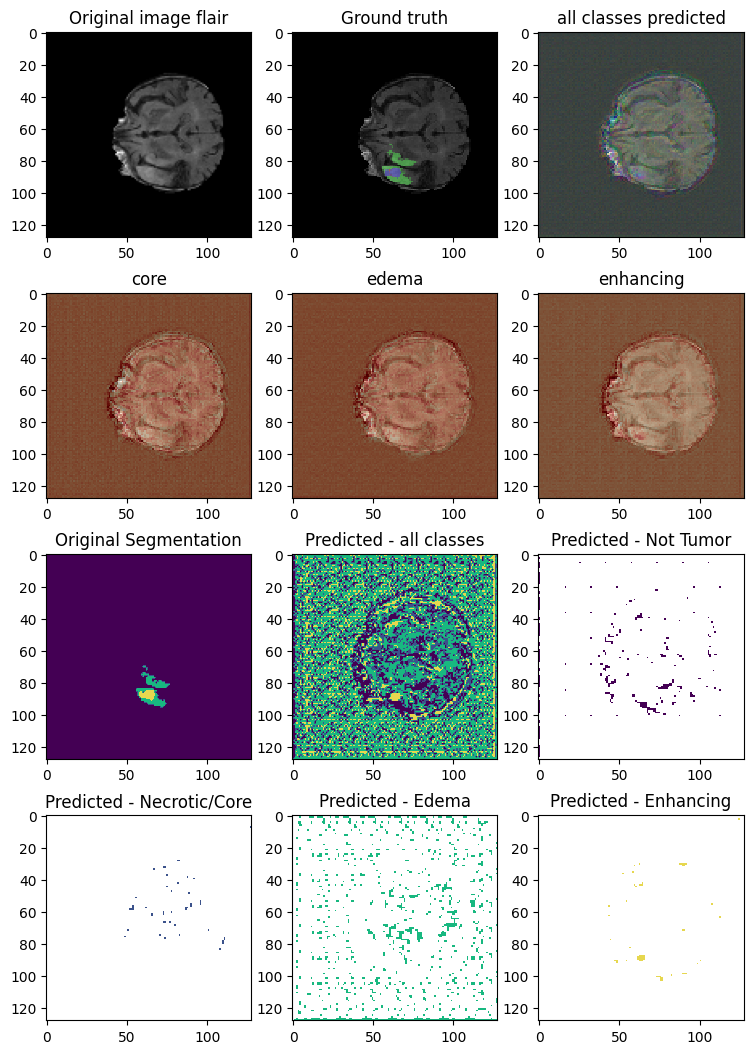

<Figure size 1000x1000 with 0 Axes>

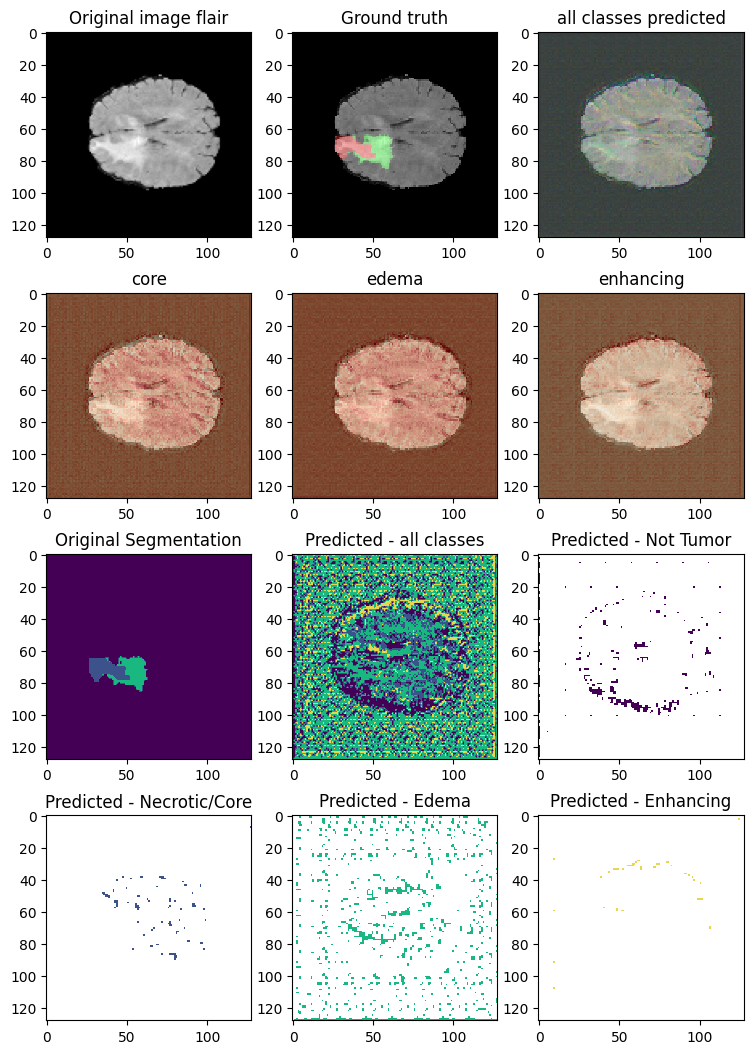

<Figure size 1000x1000 with 0 Axes>

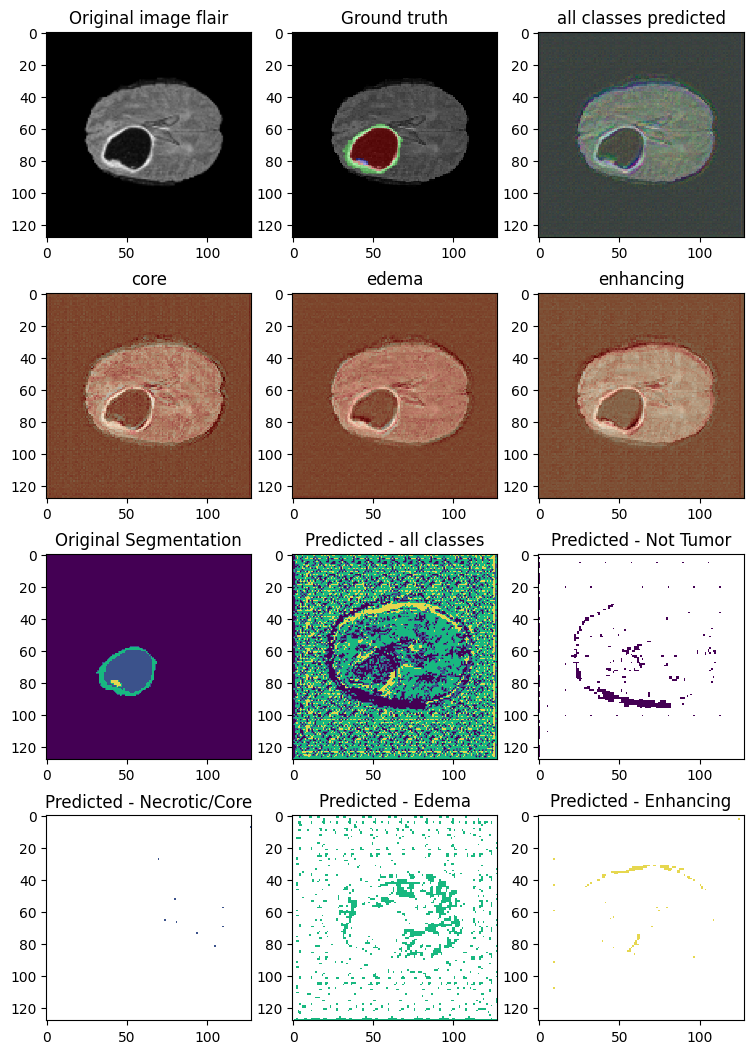

<Figure size 1000x1000 with 0 Axes>

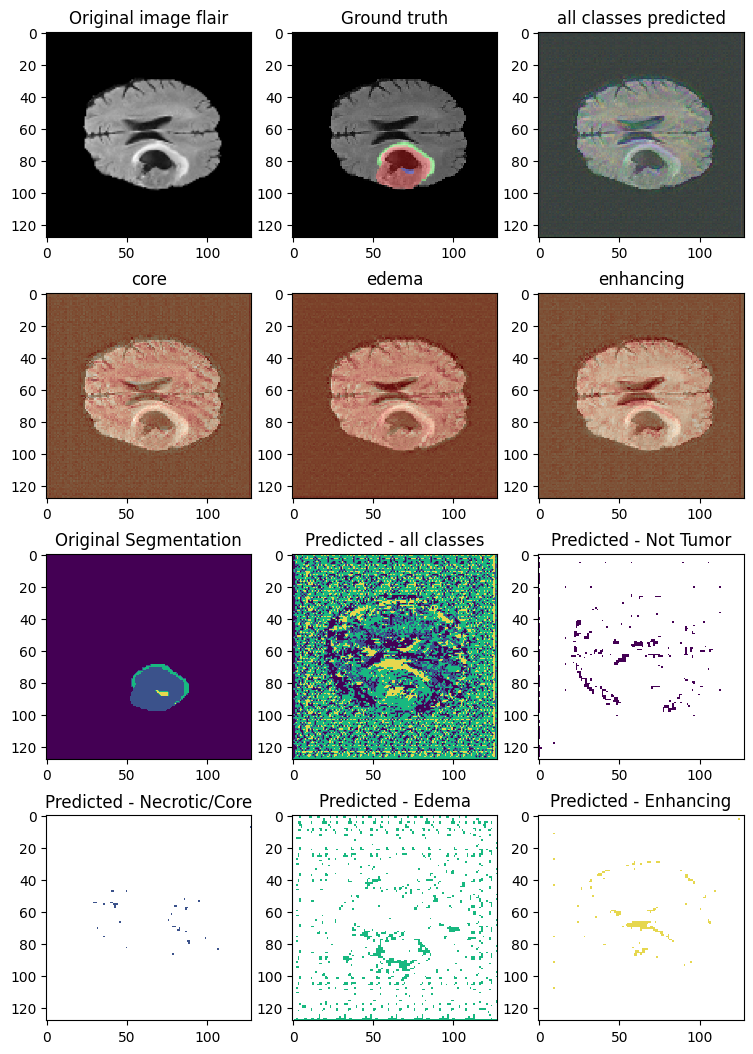

<Figure size 1000x1000 with 0 Axes>

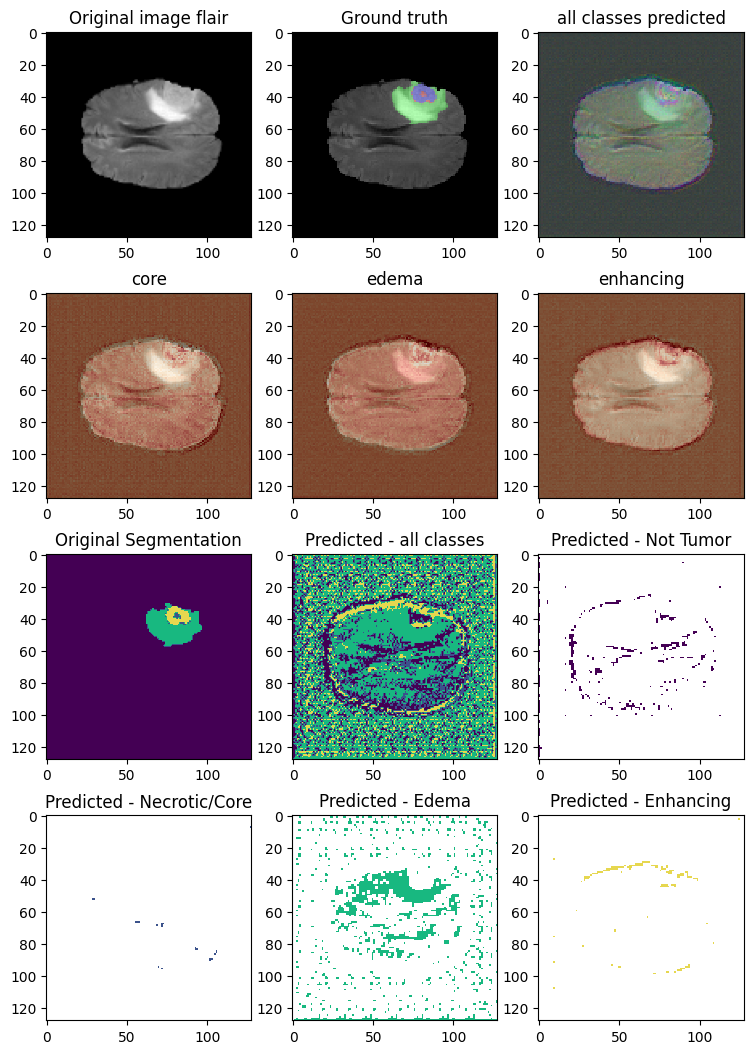

<Figure size 1000x1000 with 0 Axes>

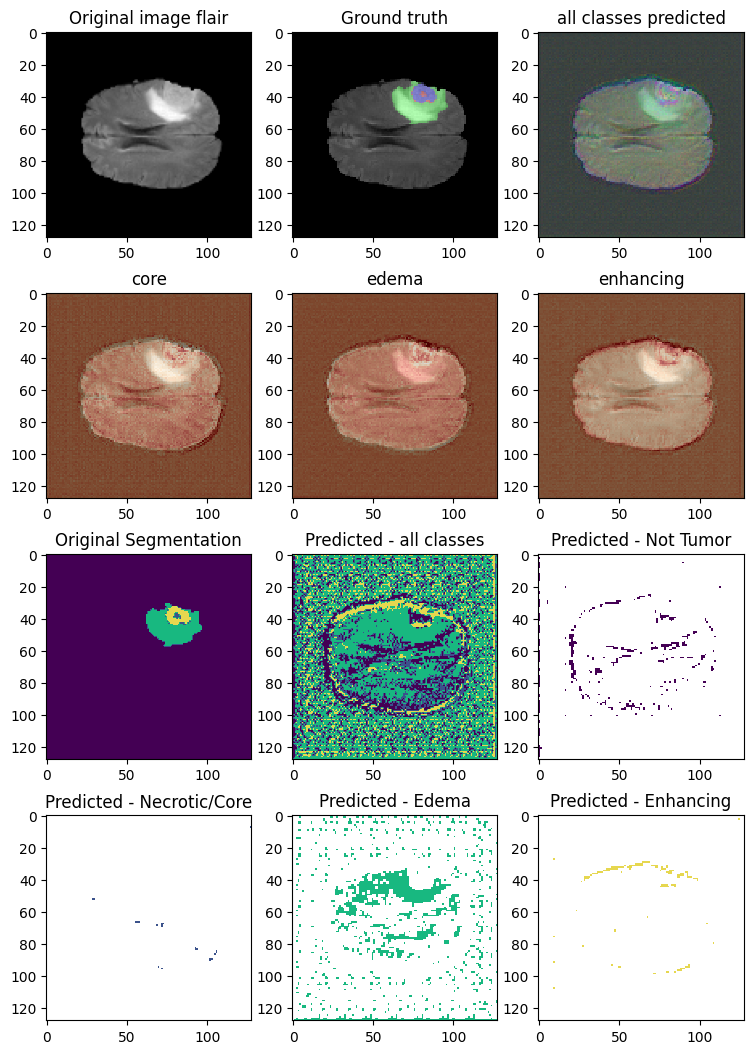

In [41]:
x, y = next(iter(test_loader))

cnt = 0

for i, (x, y) in enumerate(test_loader):
   Display_Tumor_Segmenstation(model, x, y, DEVICE)
   cnt+=1
   if cnt == 5:
     break



Display_Tumor_Segmenstation(model, x, y, DEVICE)

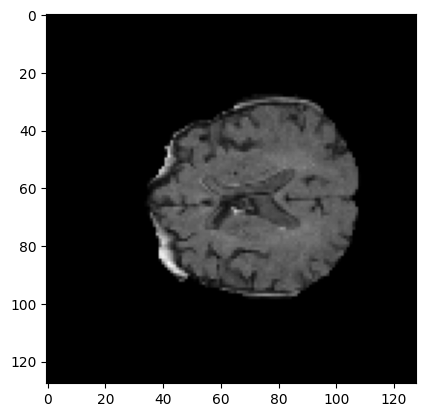

In [141]:
# plt.imshow(x[75,:,:,0], cmap='gray')

In [109]:
"""
x_.shape
x = x_.squeeze(dim=0)

print(x.shape)"""

torch.Size([96, 128, 128, 2])


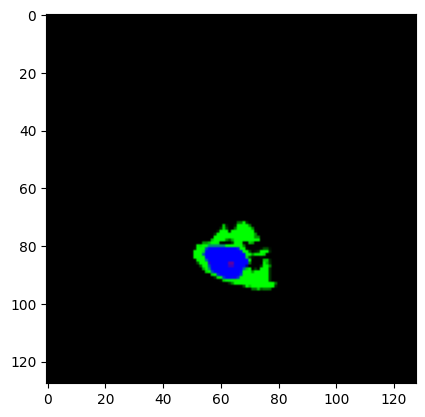

In [75]:
# plt.imshow(y[50,:,:,1:4])

In [107]:
# y = y_.squeeze(dim=0)
# y.shape

torch.Size([96, 128, 128, 4])

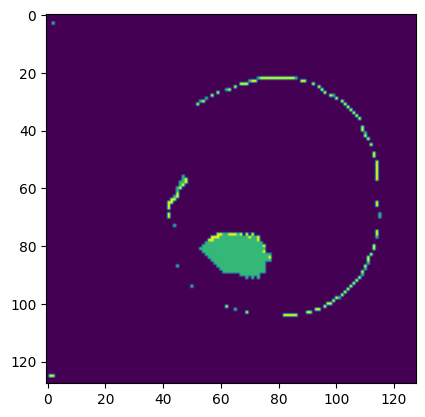

In [106]:
# plt.imshow(p_seg[50])

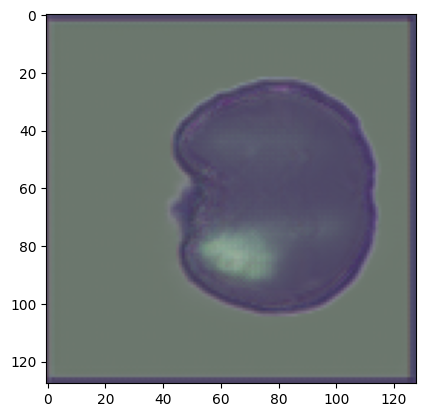

In [105]:
# plt.imshow(p[50,:,:,1:4])

In [104]:
"""
p = p.squeeze(dim=0)
p = p.permute(3, 1, 2, 0)

print(p.shape)
p_seg = torch.argmax(p, dim=-1)
print(p_seg.shape)"""

torch.Size([96, 128, 128, 4])
torch.Size([96, 128, 128])


In [143]:
"""
model.eval()
with torch.no_grad():
  x = x_.permute(0, 4, 2, 3, 1).float()
  x = x.to(DEVICE)
  p = model(x).detach().cpu()
  p = torch.sigmoid(p)
"""
